In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import pytensor.tensor as pt
from scipy.special import expit as logistic

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

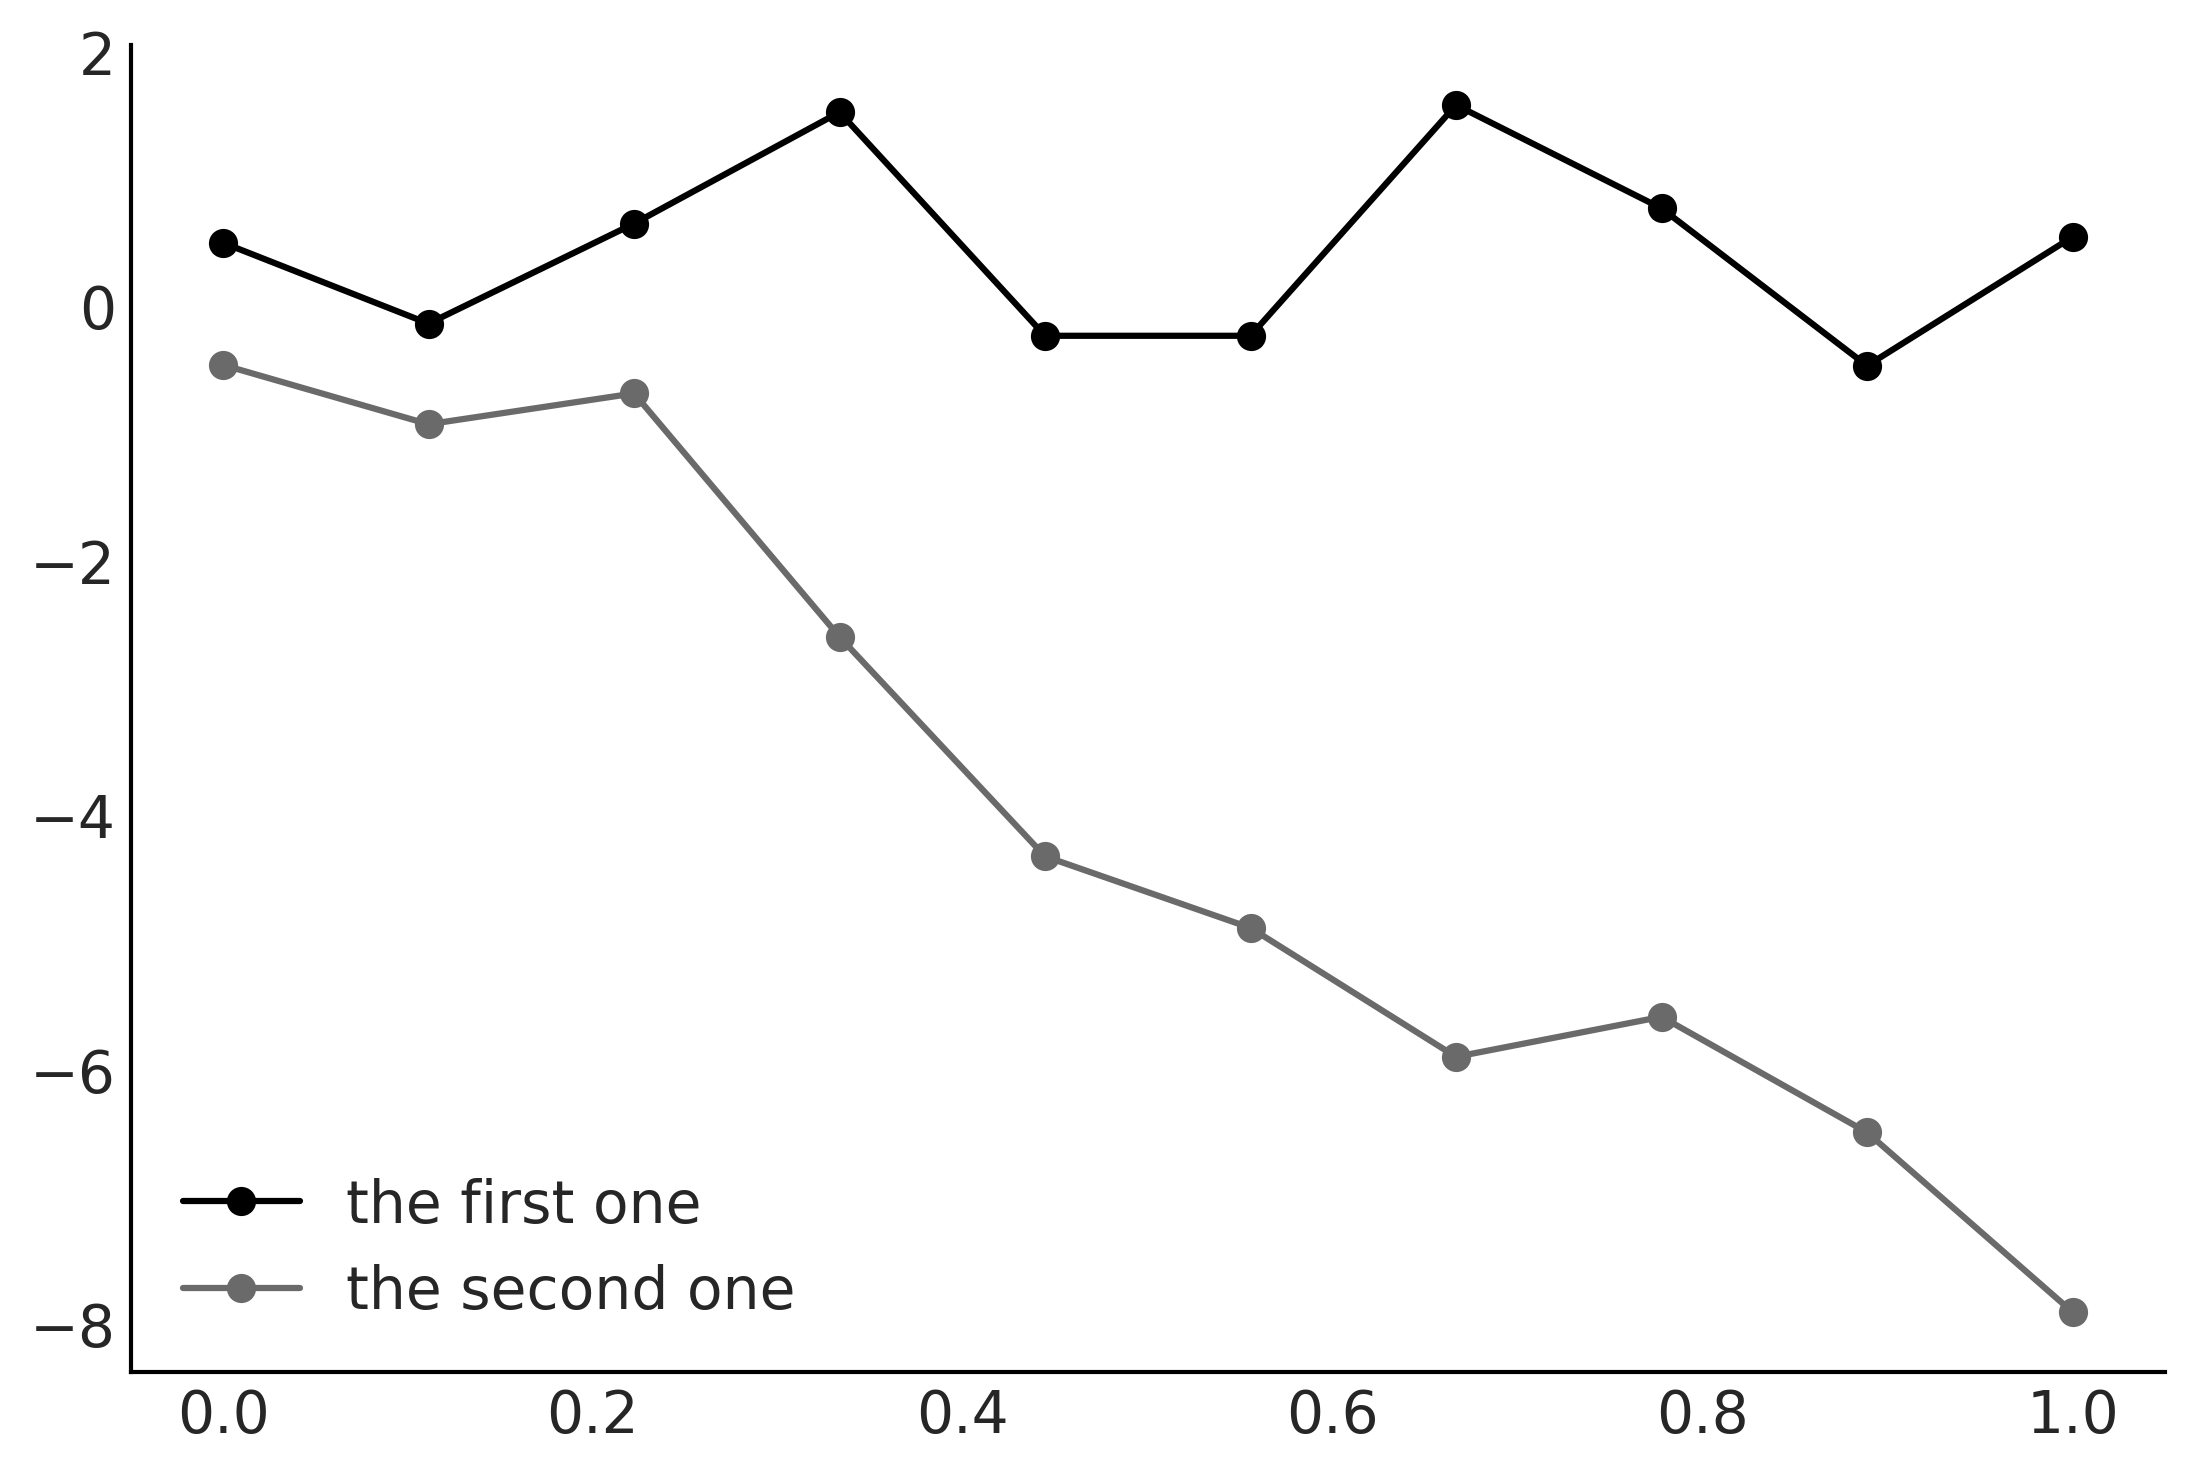

In [3]:
np.random.seed(42)
x = np.linspace(0, 1, 10)

y = np.random.normal(0, 1, len(x))
plt.plot(x, y, 'o-', label='the first one')

y = np.zeros_like(x)
for i in range(len(x)):
    y[i] = np.random.normal(y[i-1], 1)
plt.plot(x, y, 'o-', label='the second one')

plt.legend()
plt.savefig('../fig/dummy_functions.png')

### Covariance functions and kernels

In [4]:
def exp_quad_kernel(x, knots, ℓ=1):
    """exponentiated quadratic kernel"""
    return np.array([np.exp(-(x-k)**2 / (2*ℓ**2)) for k in knots])

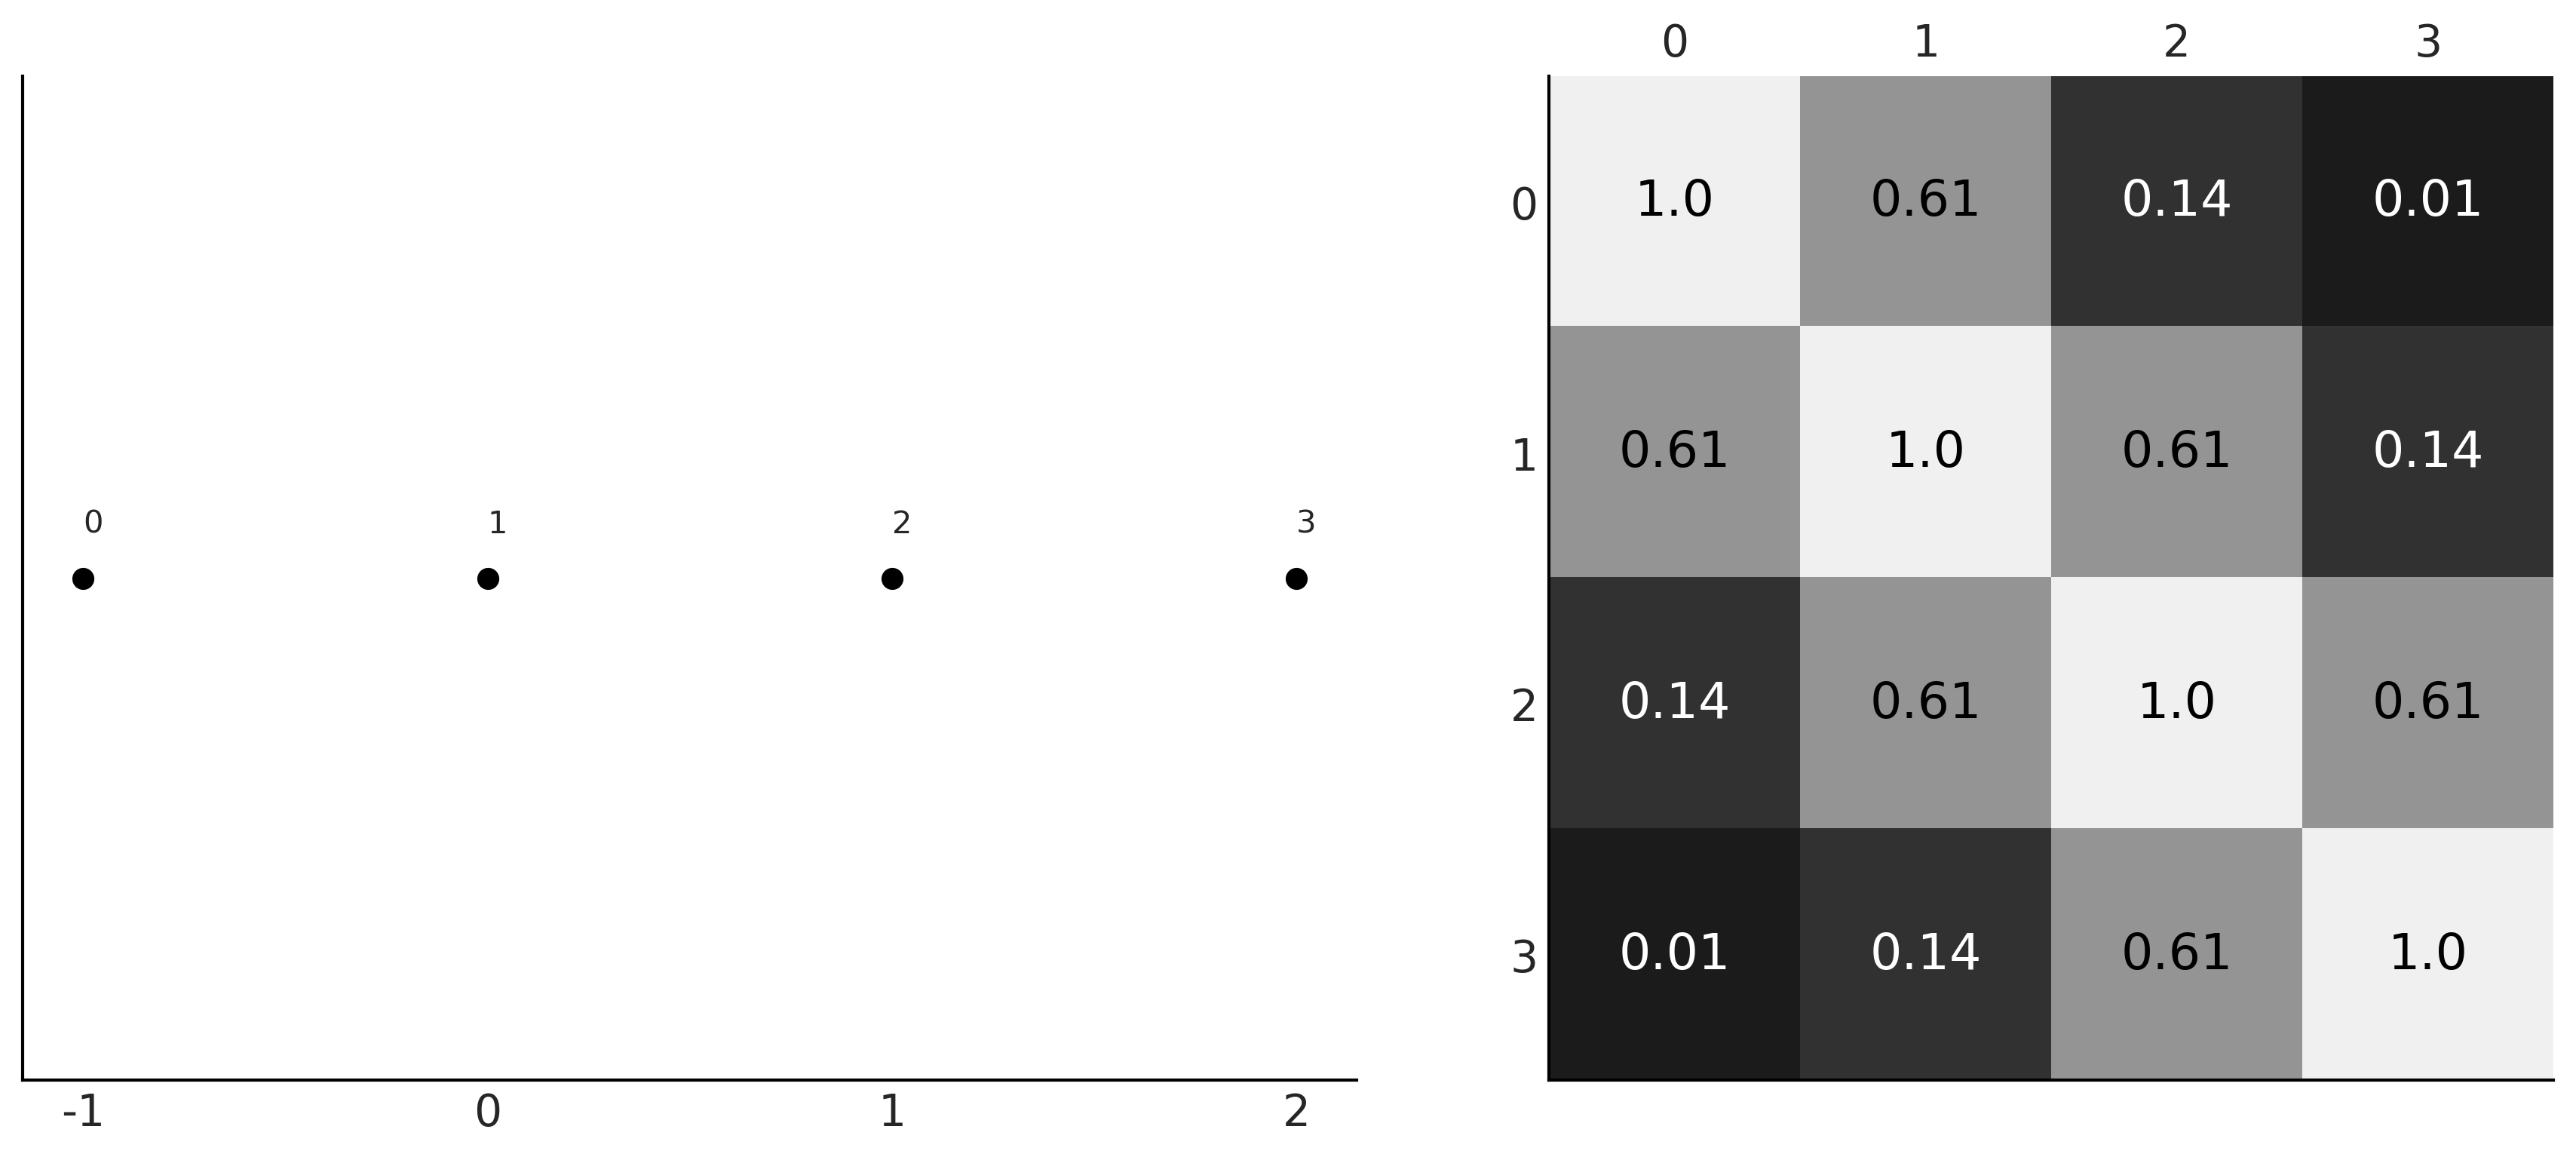

In [5]:
data = np.array([-1, 0, 1, 2])  # np.random.normal(size=4)
cov = exp_quad_kernel(data, data, 1)

_, ax = plt.subplots(1, 2, figsize=(12, 5))
ax = np.ravel(ax)

ax[0].plot(data, np.zeros_like(data), 'ko')
ax[0].set_yticks([])
for idx, i in enumerate(data):
    ax[0].text(i, 0+0.005, idx)
ax[0].set_xticks(data)
ax[0].set_xticklabels(np.round(data, 2))
#ax[0].set_xticklabels(np.round(data, 2), rotation=70)

ax[1].grid(False)
im = ax[1].imshow(cov)
colors = ['w', 'k']
for i in range(len(cov)):
    for j in range(len(cov)):
        ax[1].text(j, i, round(cov[i, j], 2),
                   color=colors[int(im.norm(cov[i, j]) > 0.5)],
                   ha='center', va='center', fontdict={'size': 16})
ax[1].set_xticks(range(len(data)))
ax[1].set_yticks(range(len(data)))
ax[1].xaxis.tick_top()
plt.savefig('../fig/dummy_cov.png')

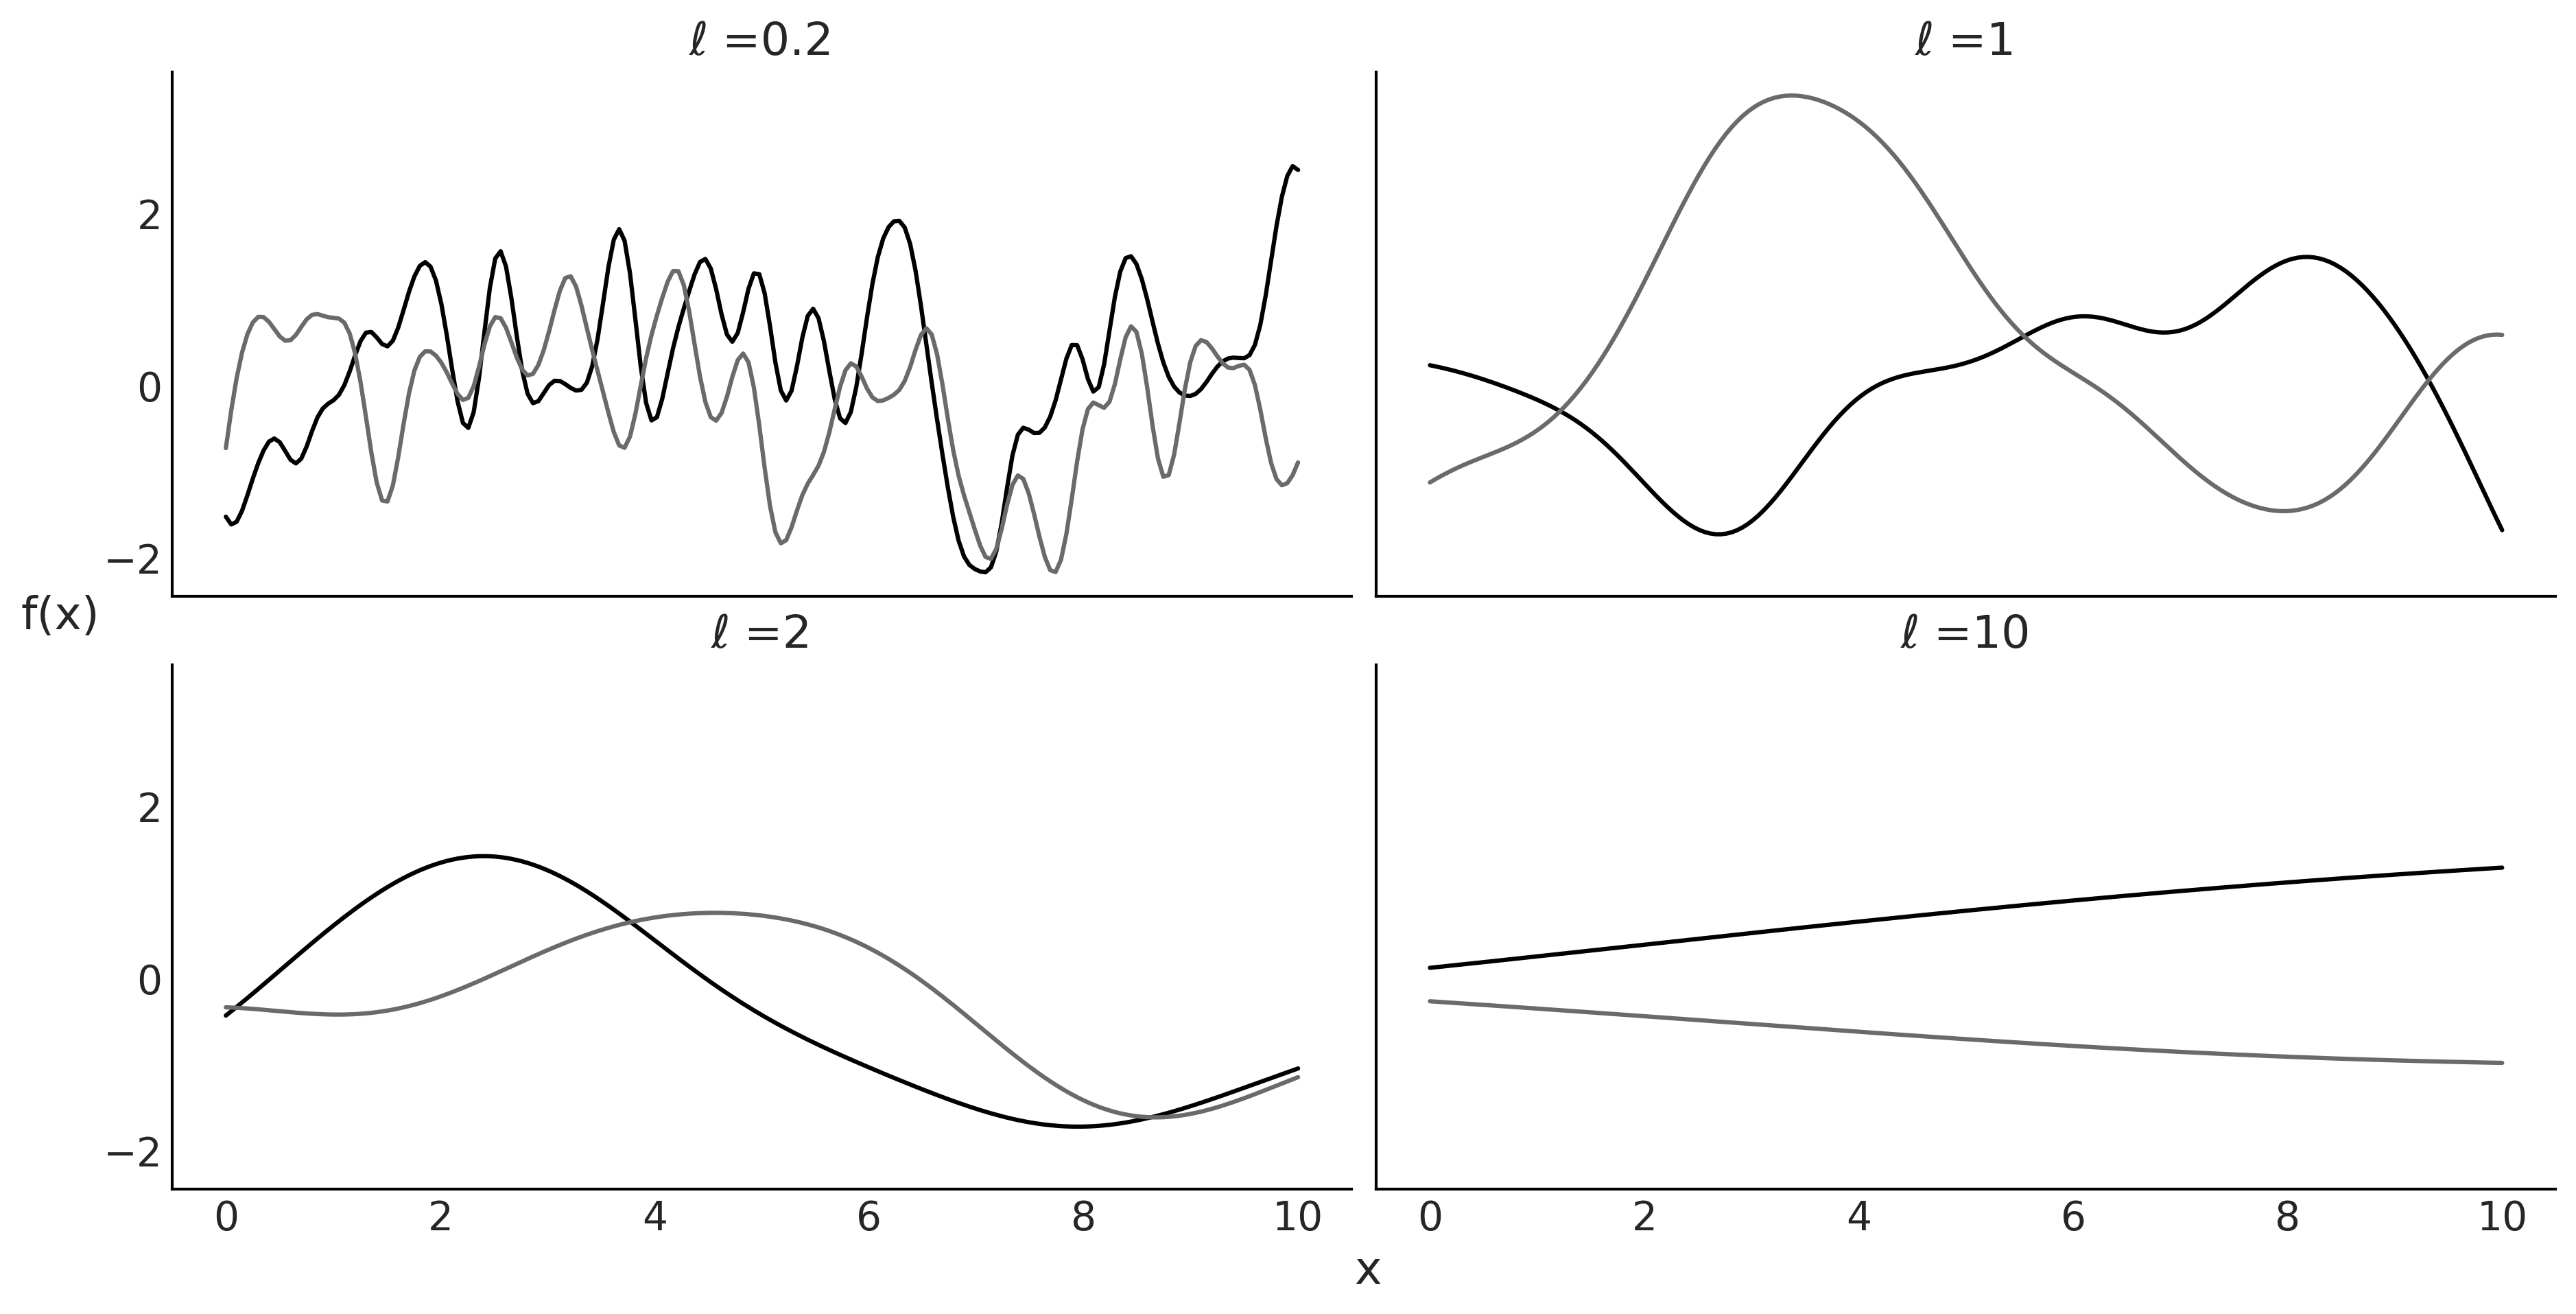

In [6]:
np.random.seed(24)
test_points = np.linspace(0, 10, 200)
fig, ax = plt.subplots(2, 2, figsize=(12, 6), sharex=True, sharey=True)
ax = np.ravel(ax)

for idx, ℓ in enumerate((0.2, 1, 2, 10)):
    cov = exp_quad_kernel(test_points, test_points, ℓ)
    ax[idx].plot(test_points, pz.MvNormal(mu=np.zeros_like(test_points), cov=cov).rvs(2).T)
    ax[idx].set_title(f'ℓ ={ℓ}')
fig.text(0.51, -0.03, 'x', fontsize=16)
fig.text(-0.03, 0.5, 'f(x)', fontsize=16)
plt.savefig('../fig/dummy_realizations.png')

## Gaussian Process regression

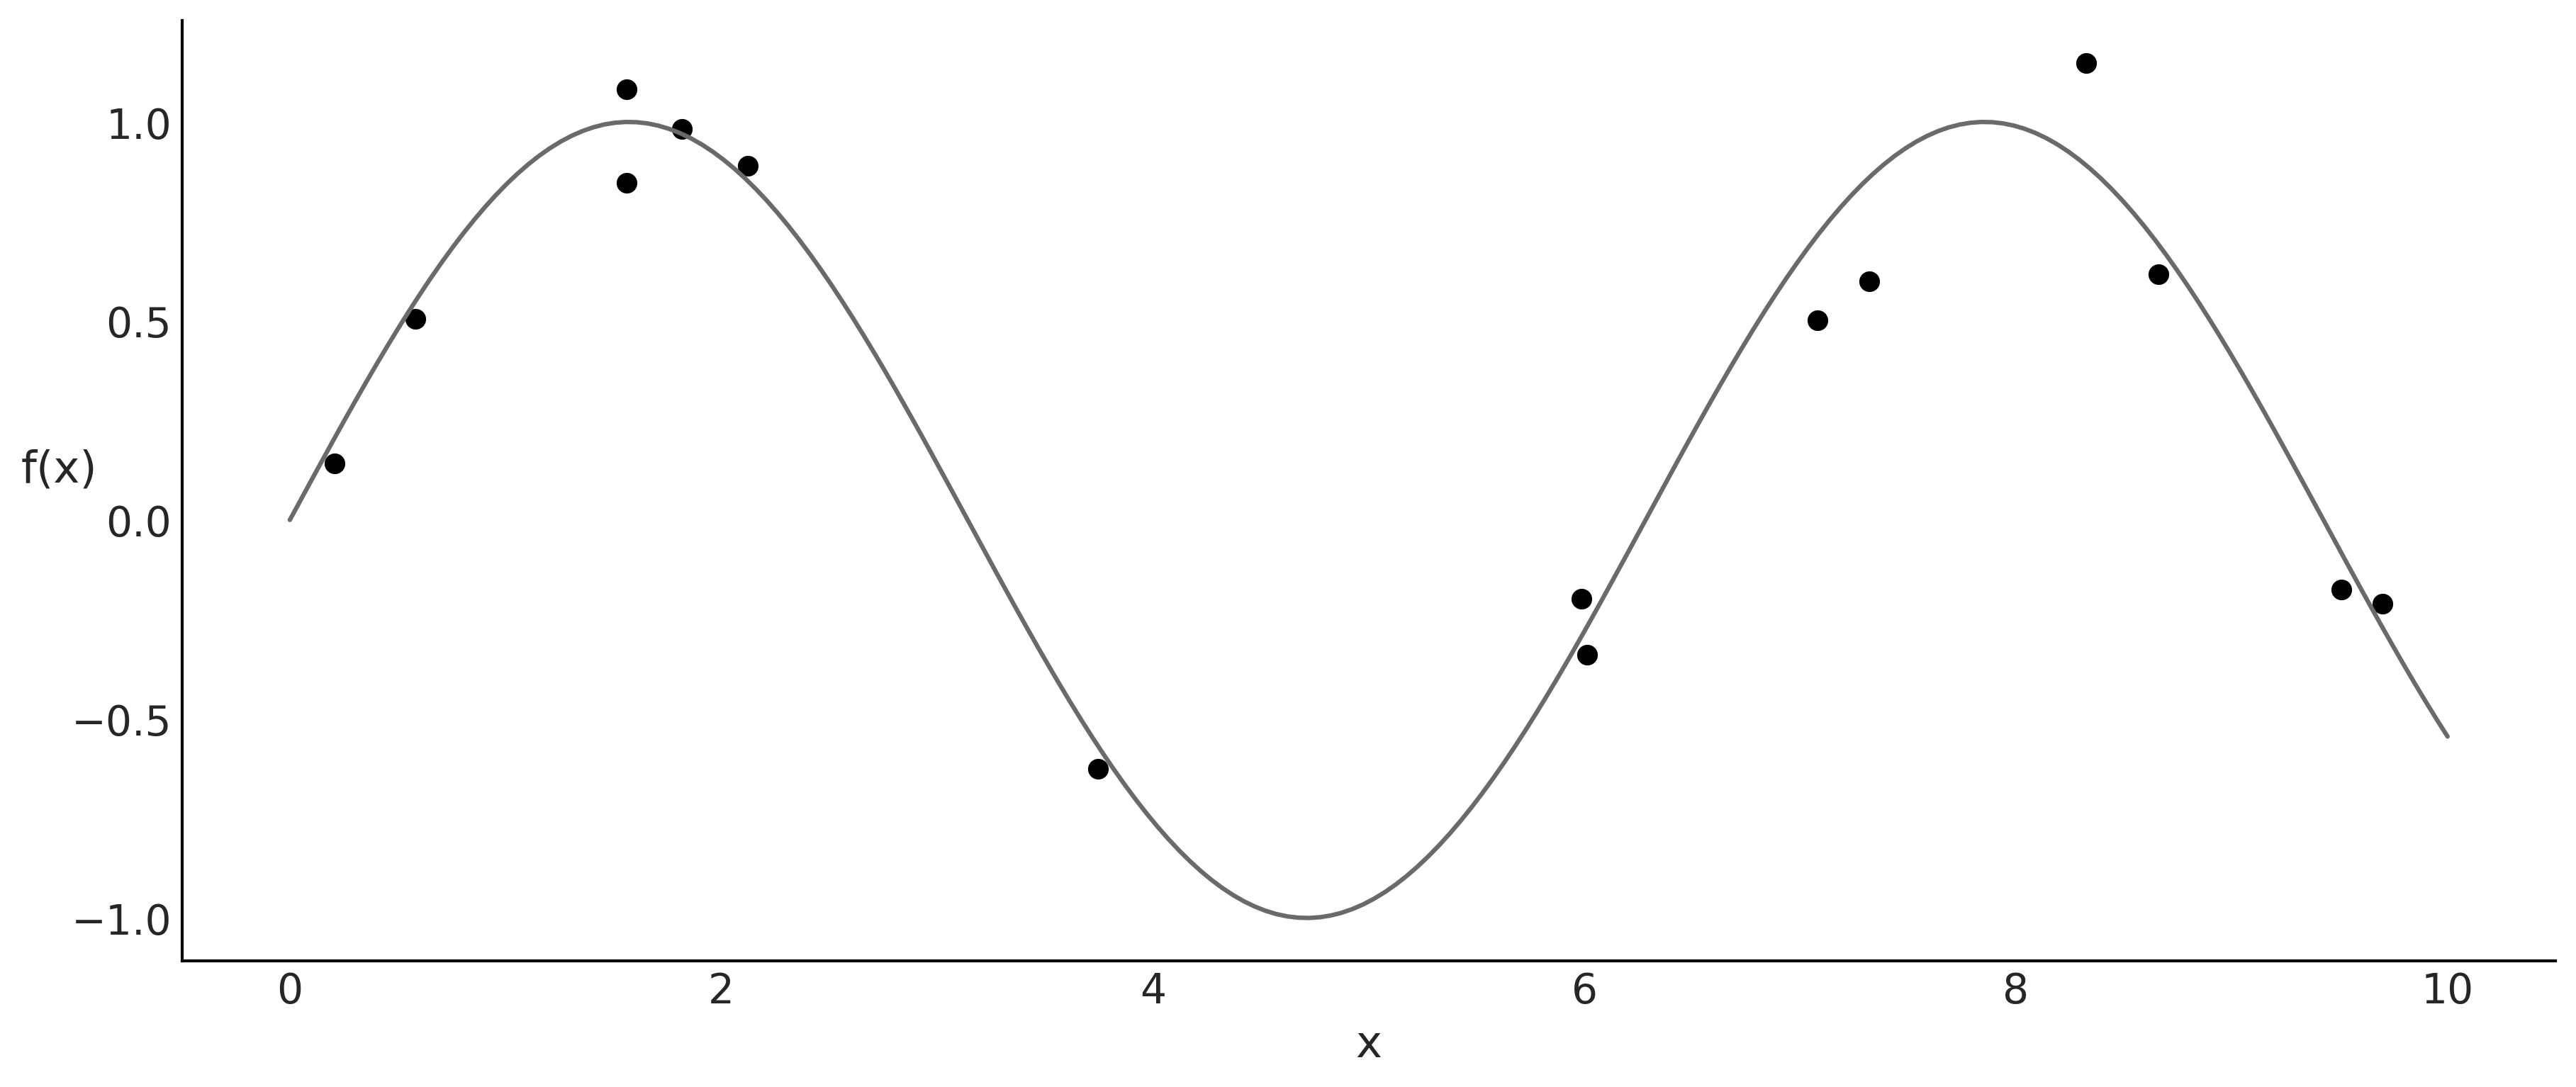

In [7]:
np.random.seed(42)
x = np.random.uniform(0, 10, size=15)
y = np.random.normal(np.sin(x), 0.1)


_, ax = plt.subplots(figsize=(12,5))
ax.plot(x, y, 'o')
true_x = np.linspace(0, 10, 200)
ax.plot(true_x, np.sin(true_x), 'C1')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0)
plt.savefig('../fig/fake_sin.png')

In [8]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))


In [9]:
# A one-dimensional column vector of inputs.
X = x[:, None]

with pm.Model() as model_reg:
    # hyperprior for lengthscale kernel parameter
    ℓ = pm.InverseGamma("ℓ", **get_ig_params(x, l_b=1))
    
    # instanciate a covariance function
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    # instanciate a GP prior
    gp = pm.gp.Marginal(cov_func=cov)

    σ = pm.HalfNormal('σ', 25)

    y_pred = gp.marginal_likelihood('y_pred', X=X, y=y, sigma=σ)
    idata_reg = pm.sample(random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


In [10]:
X_new = np.linspace(np.floor(x.min()), np.ceil(x.max()), 100)[:,None]

with model_reg:
    f_pred = gp.conditional('f_pred', X_new)

In [11]:
with model_reg:
    idata_reg_subset = idata_reg.sel(draw=slice(0, None, 100))
    pred_samples = pm.sample_posterior_predictive(idata_reg_subset,
                                                  var_names=["f_pred"],
                                                  random_seed=123)

f_pred = (pred_samples.
          posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
          values)

Sampling: [f_pred]


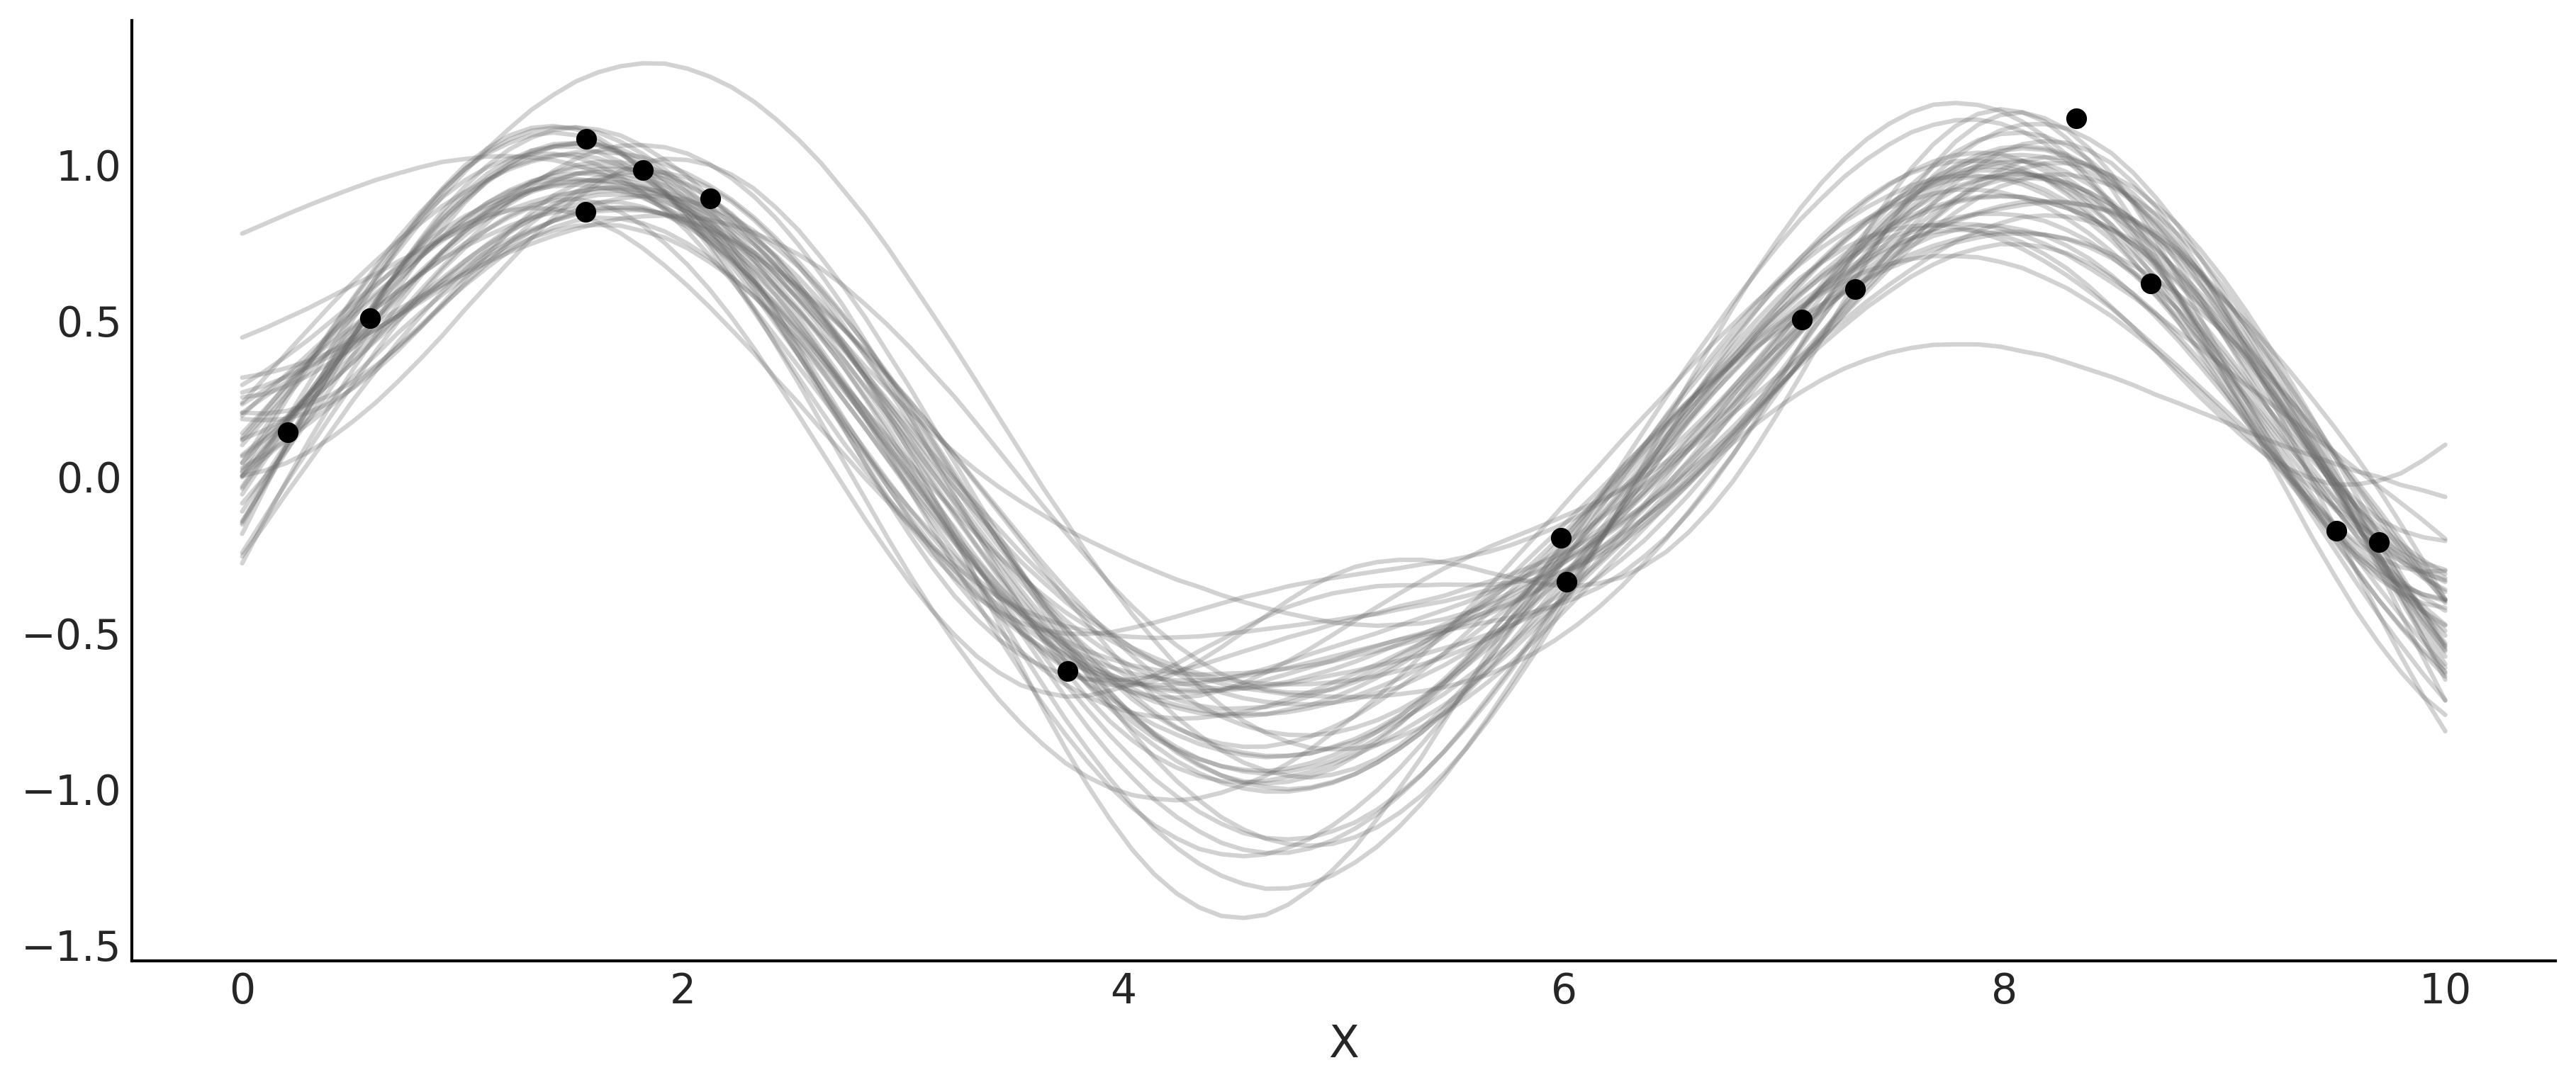

In [12]:
_, ax = plt.subplots(figsize=(12,5))
ax.plot(X_new, f_pred, 'C1-', alpha=0.3)
ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('../fig/GP_sd_fit_lines.png')

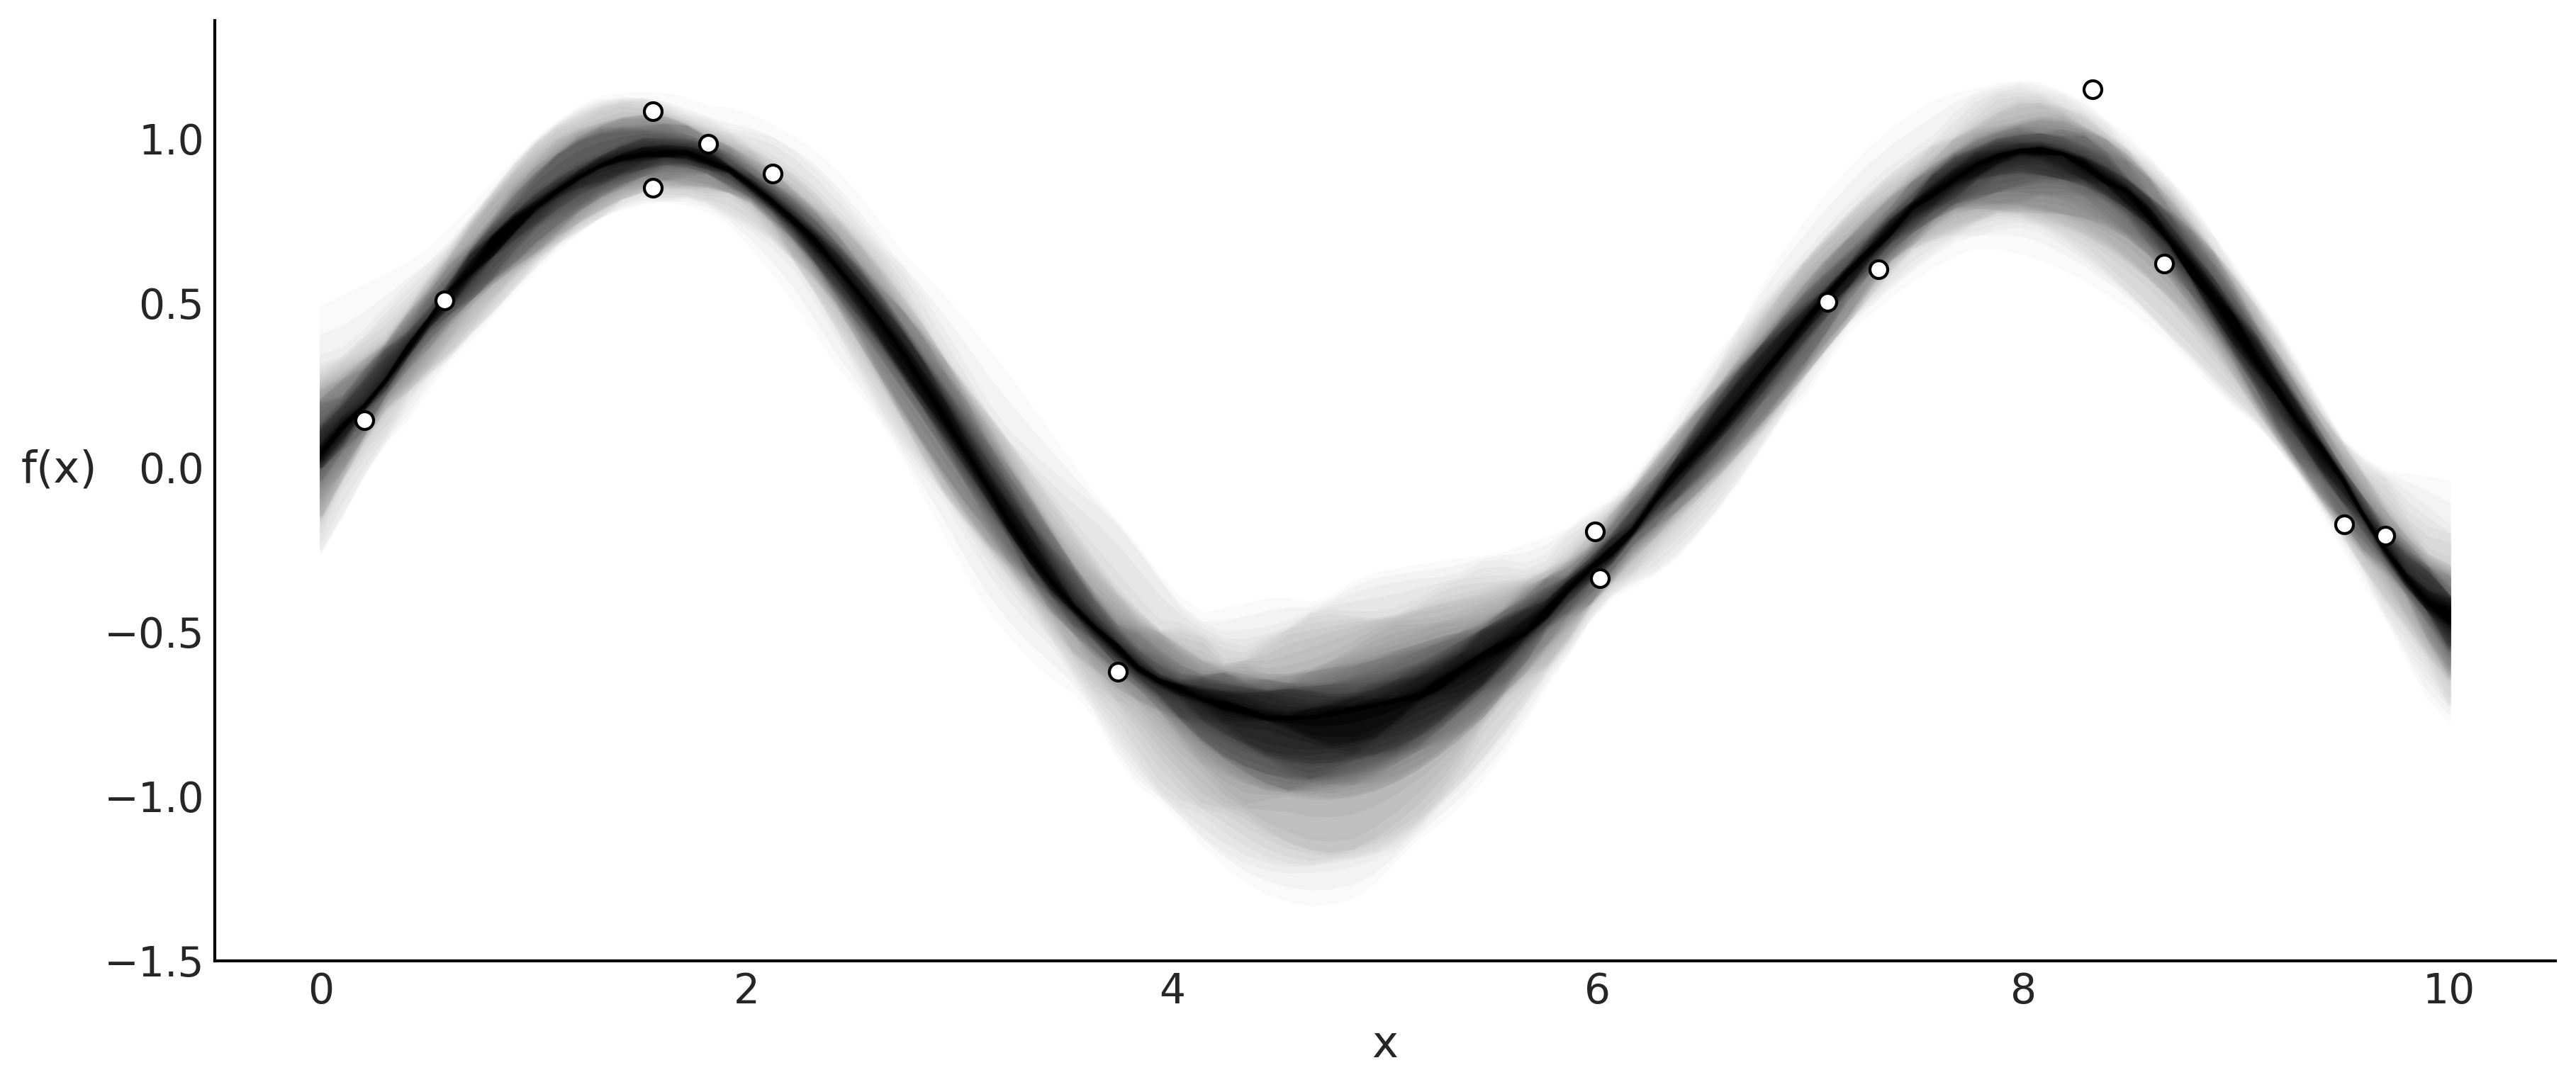

In [13]:
_, ax = plt.subplots(figsize=(12,5))

pm.gp.util.plot_gp_dist(ax, f_pred.T, X_new, palette='gray_r', plot_samples=False);

ax.plot(X, y, 'wo', mec='k')
ax.set_xlabel('x')
ax.set_ylabel('f(x)', rotation=0, labelpad=15)
plt.savefig('../fig/GP_sd_fit_dist.png')

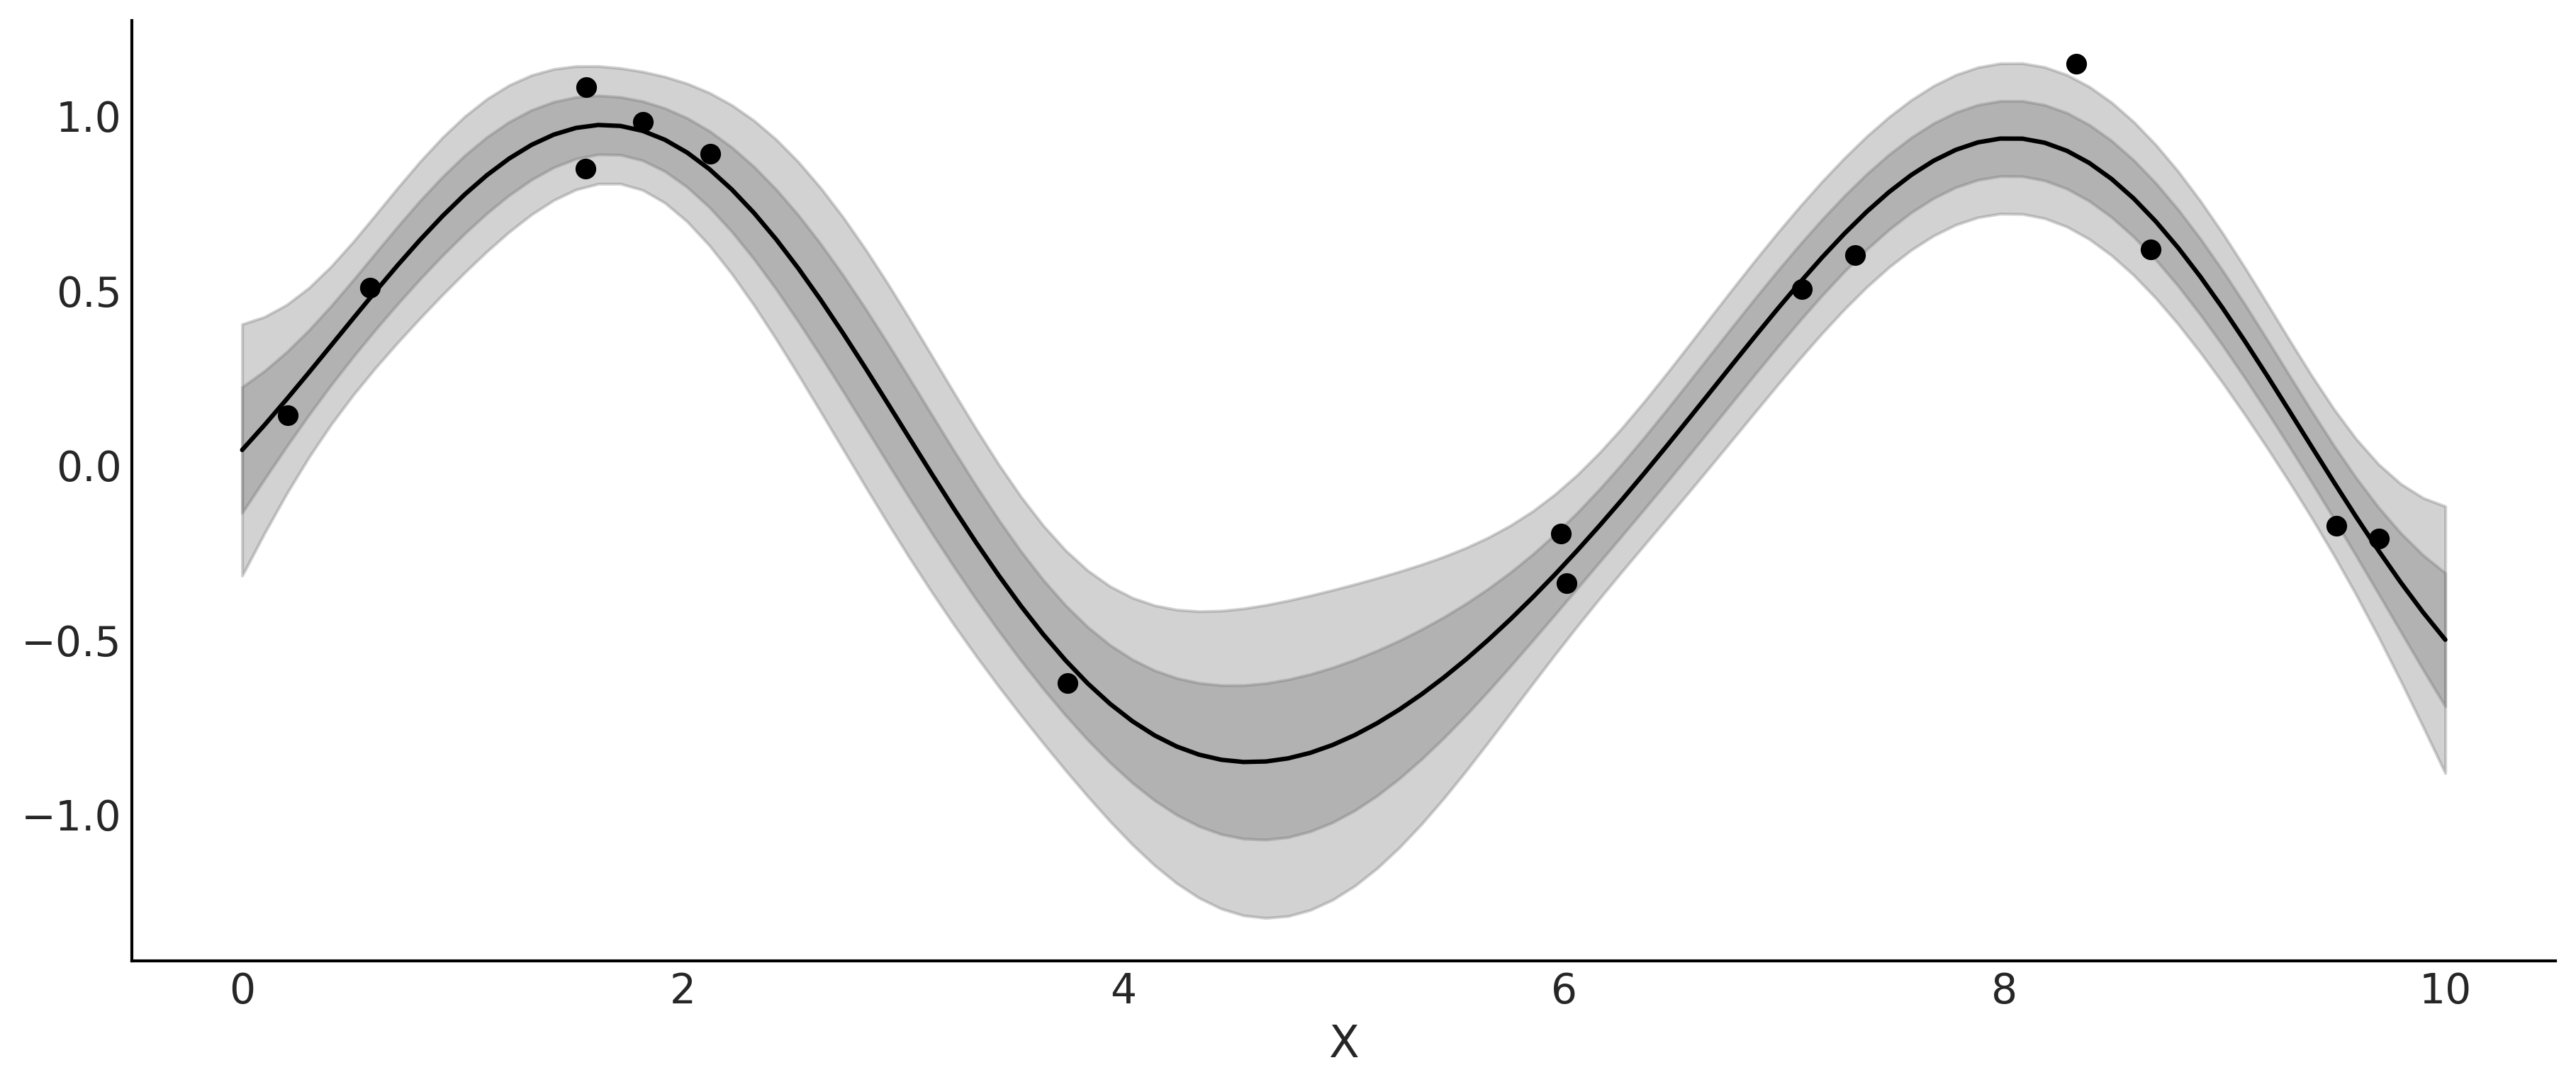

In [14]:
# plot the results
_, ax = plt.subplots(figsize=(12,5))

# predict
point = {'ℓ': idata_reg.posterior['ℓ'].mean(), 'σ': idata_reg.posterior['σ'].mean()}
mu, var = gp.predict(X_new, point=point, diag=True,  model=model_reg)
sd = var**0.5

# plot mean and 1σ and 2σ intervals
ax.plot(X_new, mu, 'C0')
ax.fill_between(X_new.flatten(),
                 mu - sd, mu + sd,
                 color="C1",
                 alpha=0.3)

ax.fill_between(X_new.flatten(),
                 mu - 2*sd, mu + 2*sd,
                 color="C1",
                 alpha=0.3)

ax.plot(X, y, 'ko')
ax.set_xlabel('X')
plt.savefig('../fig/GP_sd_fit_bands.png')

### Gaussian process classification

In [15]:
iris = pd.read_csv('data/iris.csv')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

In [16]:
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_1 = df['sepal_length'].values
X_1 = x_1[:, None]

In [17]:
with pm.Model() as model_iris:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_1))
    cov = pm.gp.cov.ExpQuad(1, ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris = pm.sample(nuts_sampler="nutpie", random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run SolveTriangular{trans=0, unit_diagonal=False, lower=False, check_finite=True, b_ndim=2}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373

In [18]:
X_new = np.linspace(np.floor(x_1.min()), np.ceil(x_1.max()), 200)[:, None]
with model_iris:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_iris_subset = idata_iris.sel(draw=slice(0, None, 100))
    pred_samples = pm.sample_posterior_predictive(idata_iris_subset, var_names=["f_pred"], random_seed=123)


f_pred_iris = (pred_samples.
               posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
               values)

Sampling: [f_pred]


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


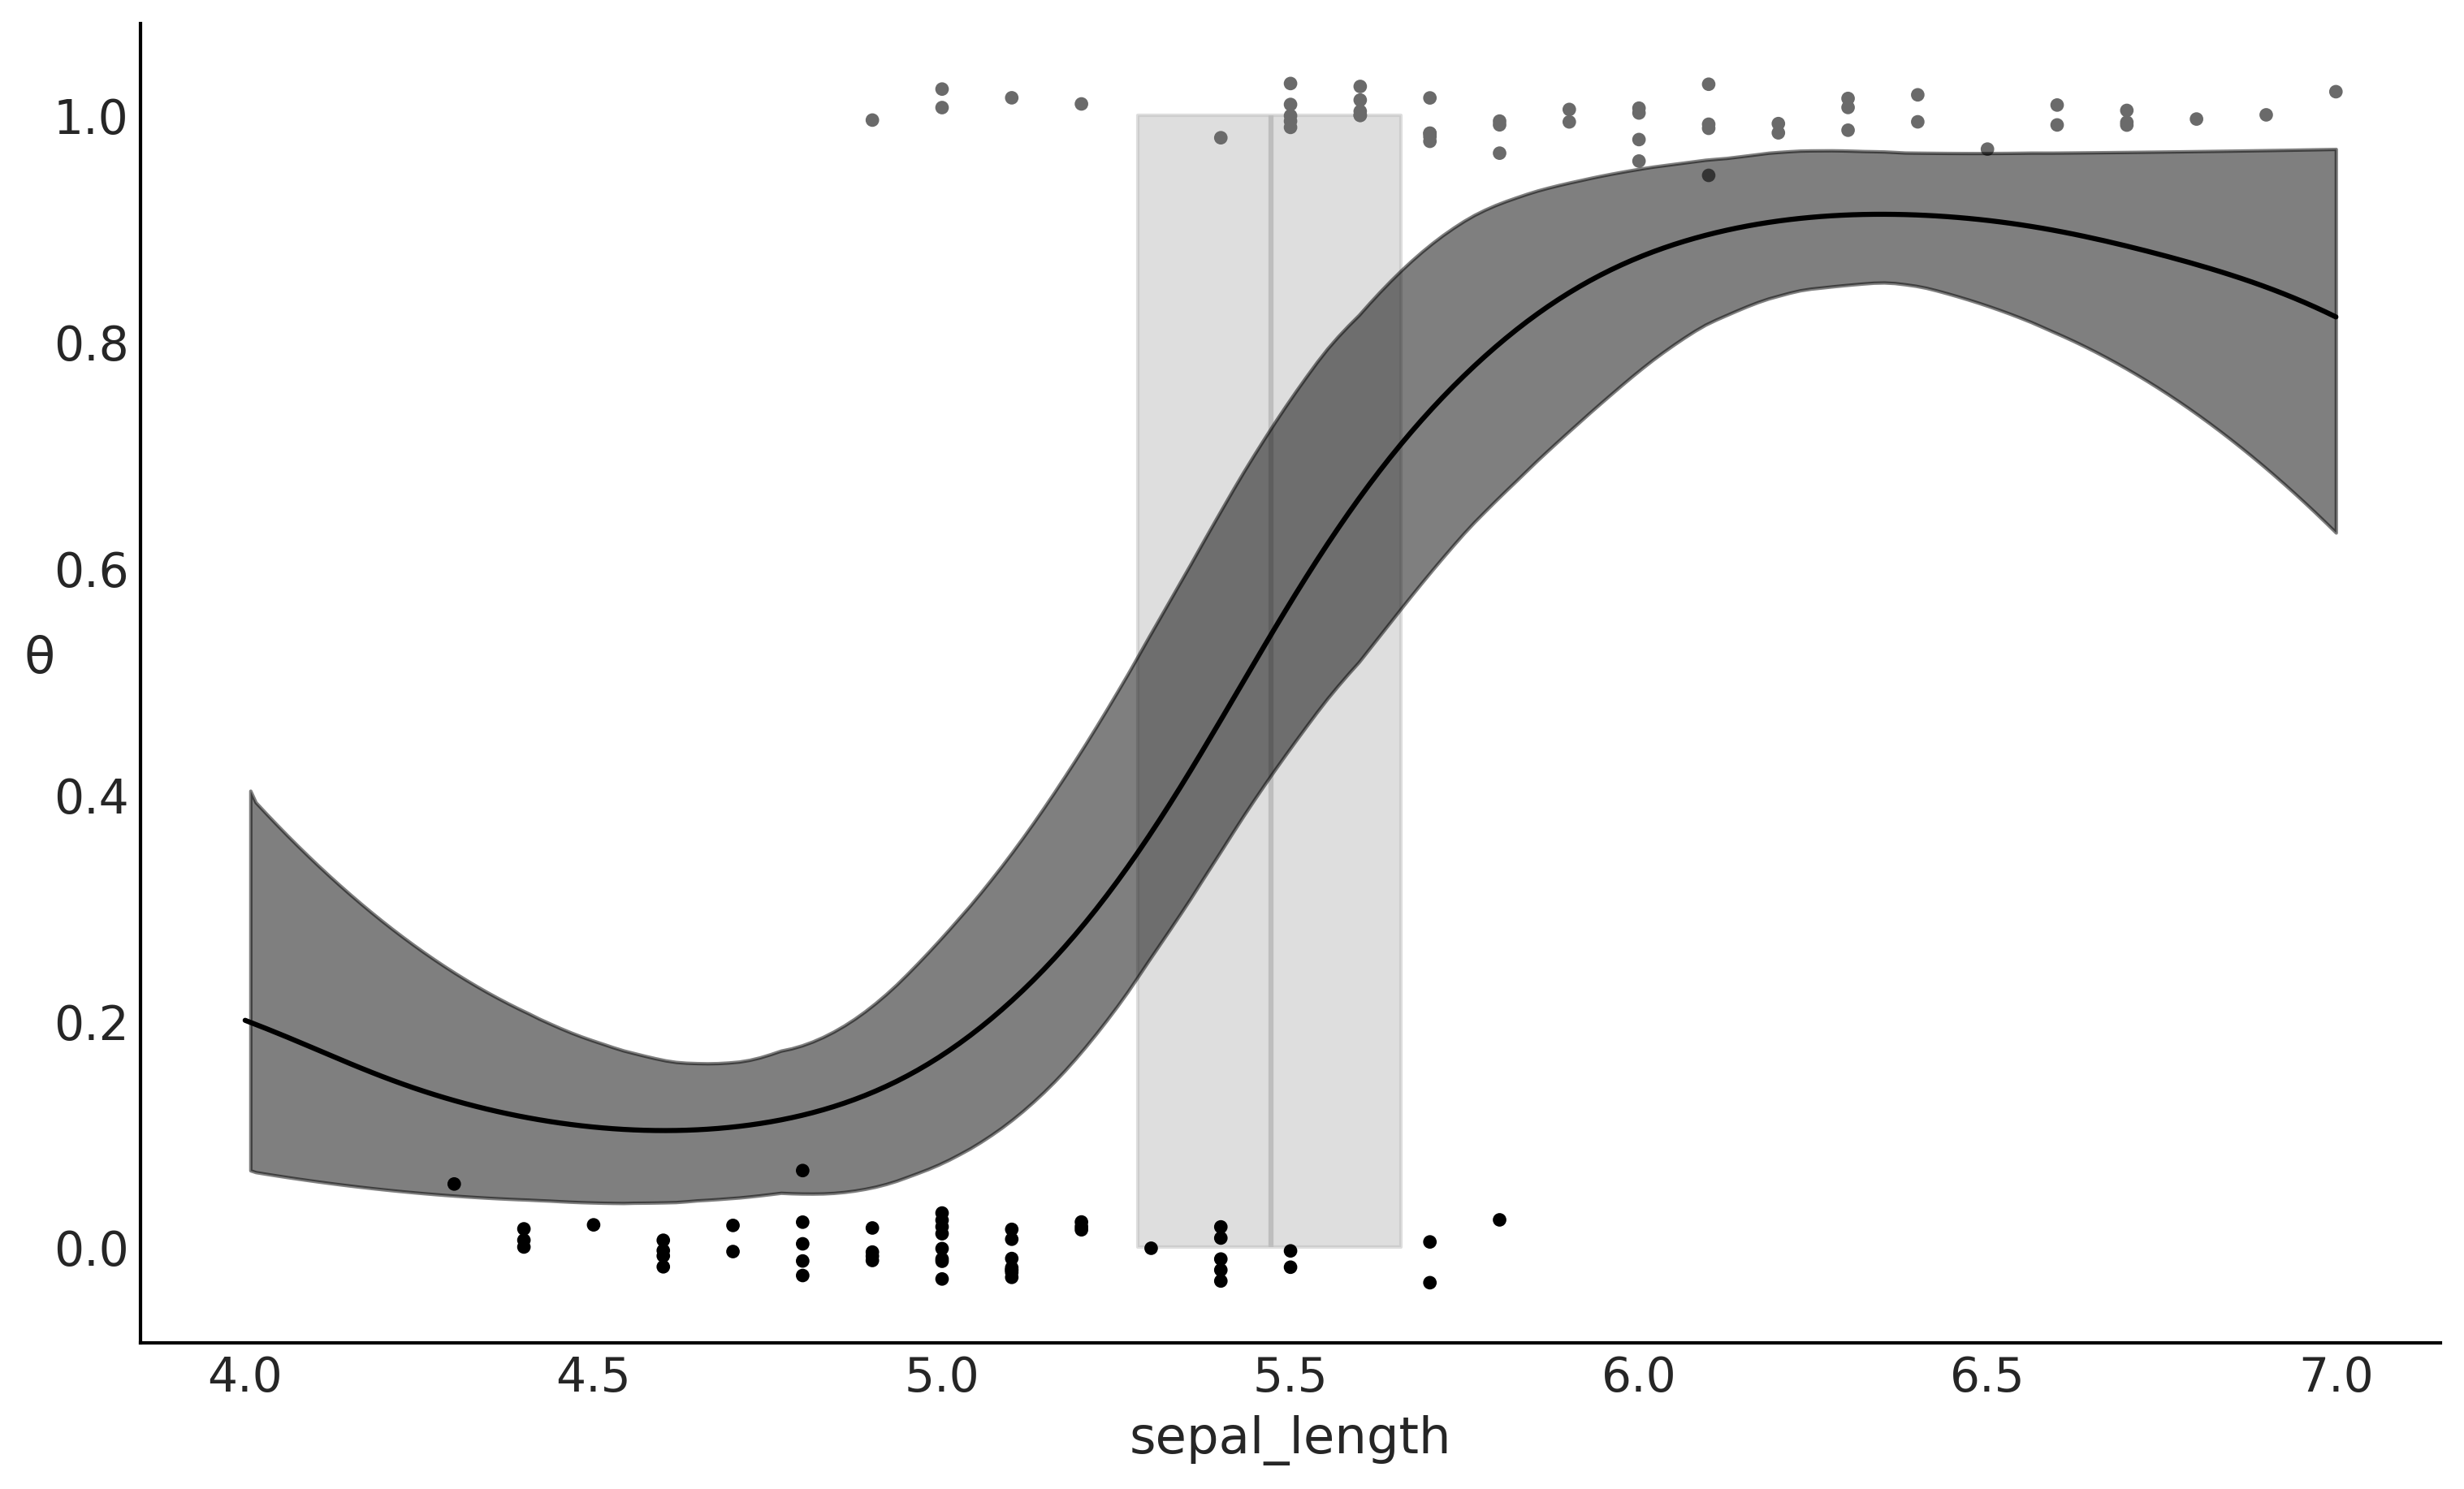

In [19]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_iris)
fp_mean = np.mean(fp, 1)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp.T, color='C0')

decision_boundary = 0.5
db = X_new[:,0][np.argmin(np.abs(fp - decision_boundary), 0)]
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='C2', zorder=-1)
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='C2', alpha=0.5, zorder=-1)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('../fig/GP_logistic_regression.png')

In [20]:
with pm.Model() as model_iris2:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_1))
    c = pm.Normal('c', x_1.min())
    τ = pm.HalfNormal('τ', 5)
    cov = (pm.gp.cov.ExpQuad(1, ℓ) +
           τ * pm.gp.cov.Linear(1, c) +
           pm.gp.cov.WhiteNoise(1E-5))
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=X_1)
    # logistic inverse link function and Bernoulli likelihood
    y_ = pm.Bernoulli("y", p=pm.math.sigmoid(f), observed=y)
    idata_iris2 = pm.sample(nuts_sampler="nutpie", random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run SolveTriangular{tr

In [21]:
with model_iris2:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_iris2_subset = idata_iris2.sel(draw=slice(0, None, 100))
    pred_samples2 = pm.sample_posterior_predictive(idata_iris2_subset,
                                                   var_names=["f_pred"],
                                                   random_seed=123)


f_pred_iris2 = (pred_samples2.
                posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
                values)                                   

Sampling: [f_pred]


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


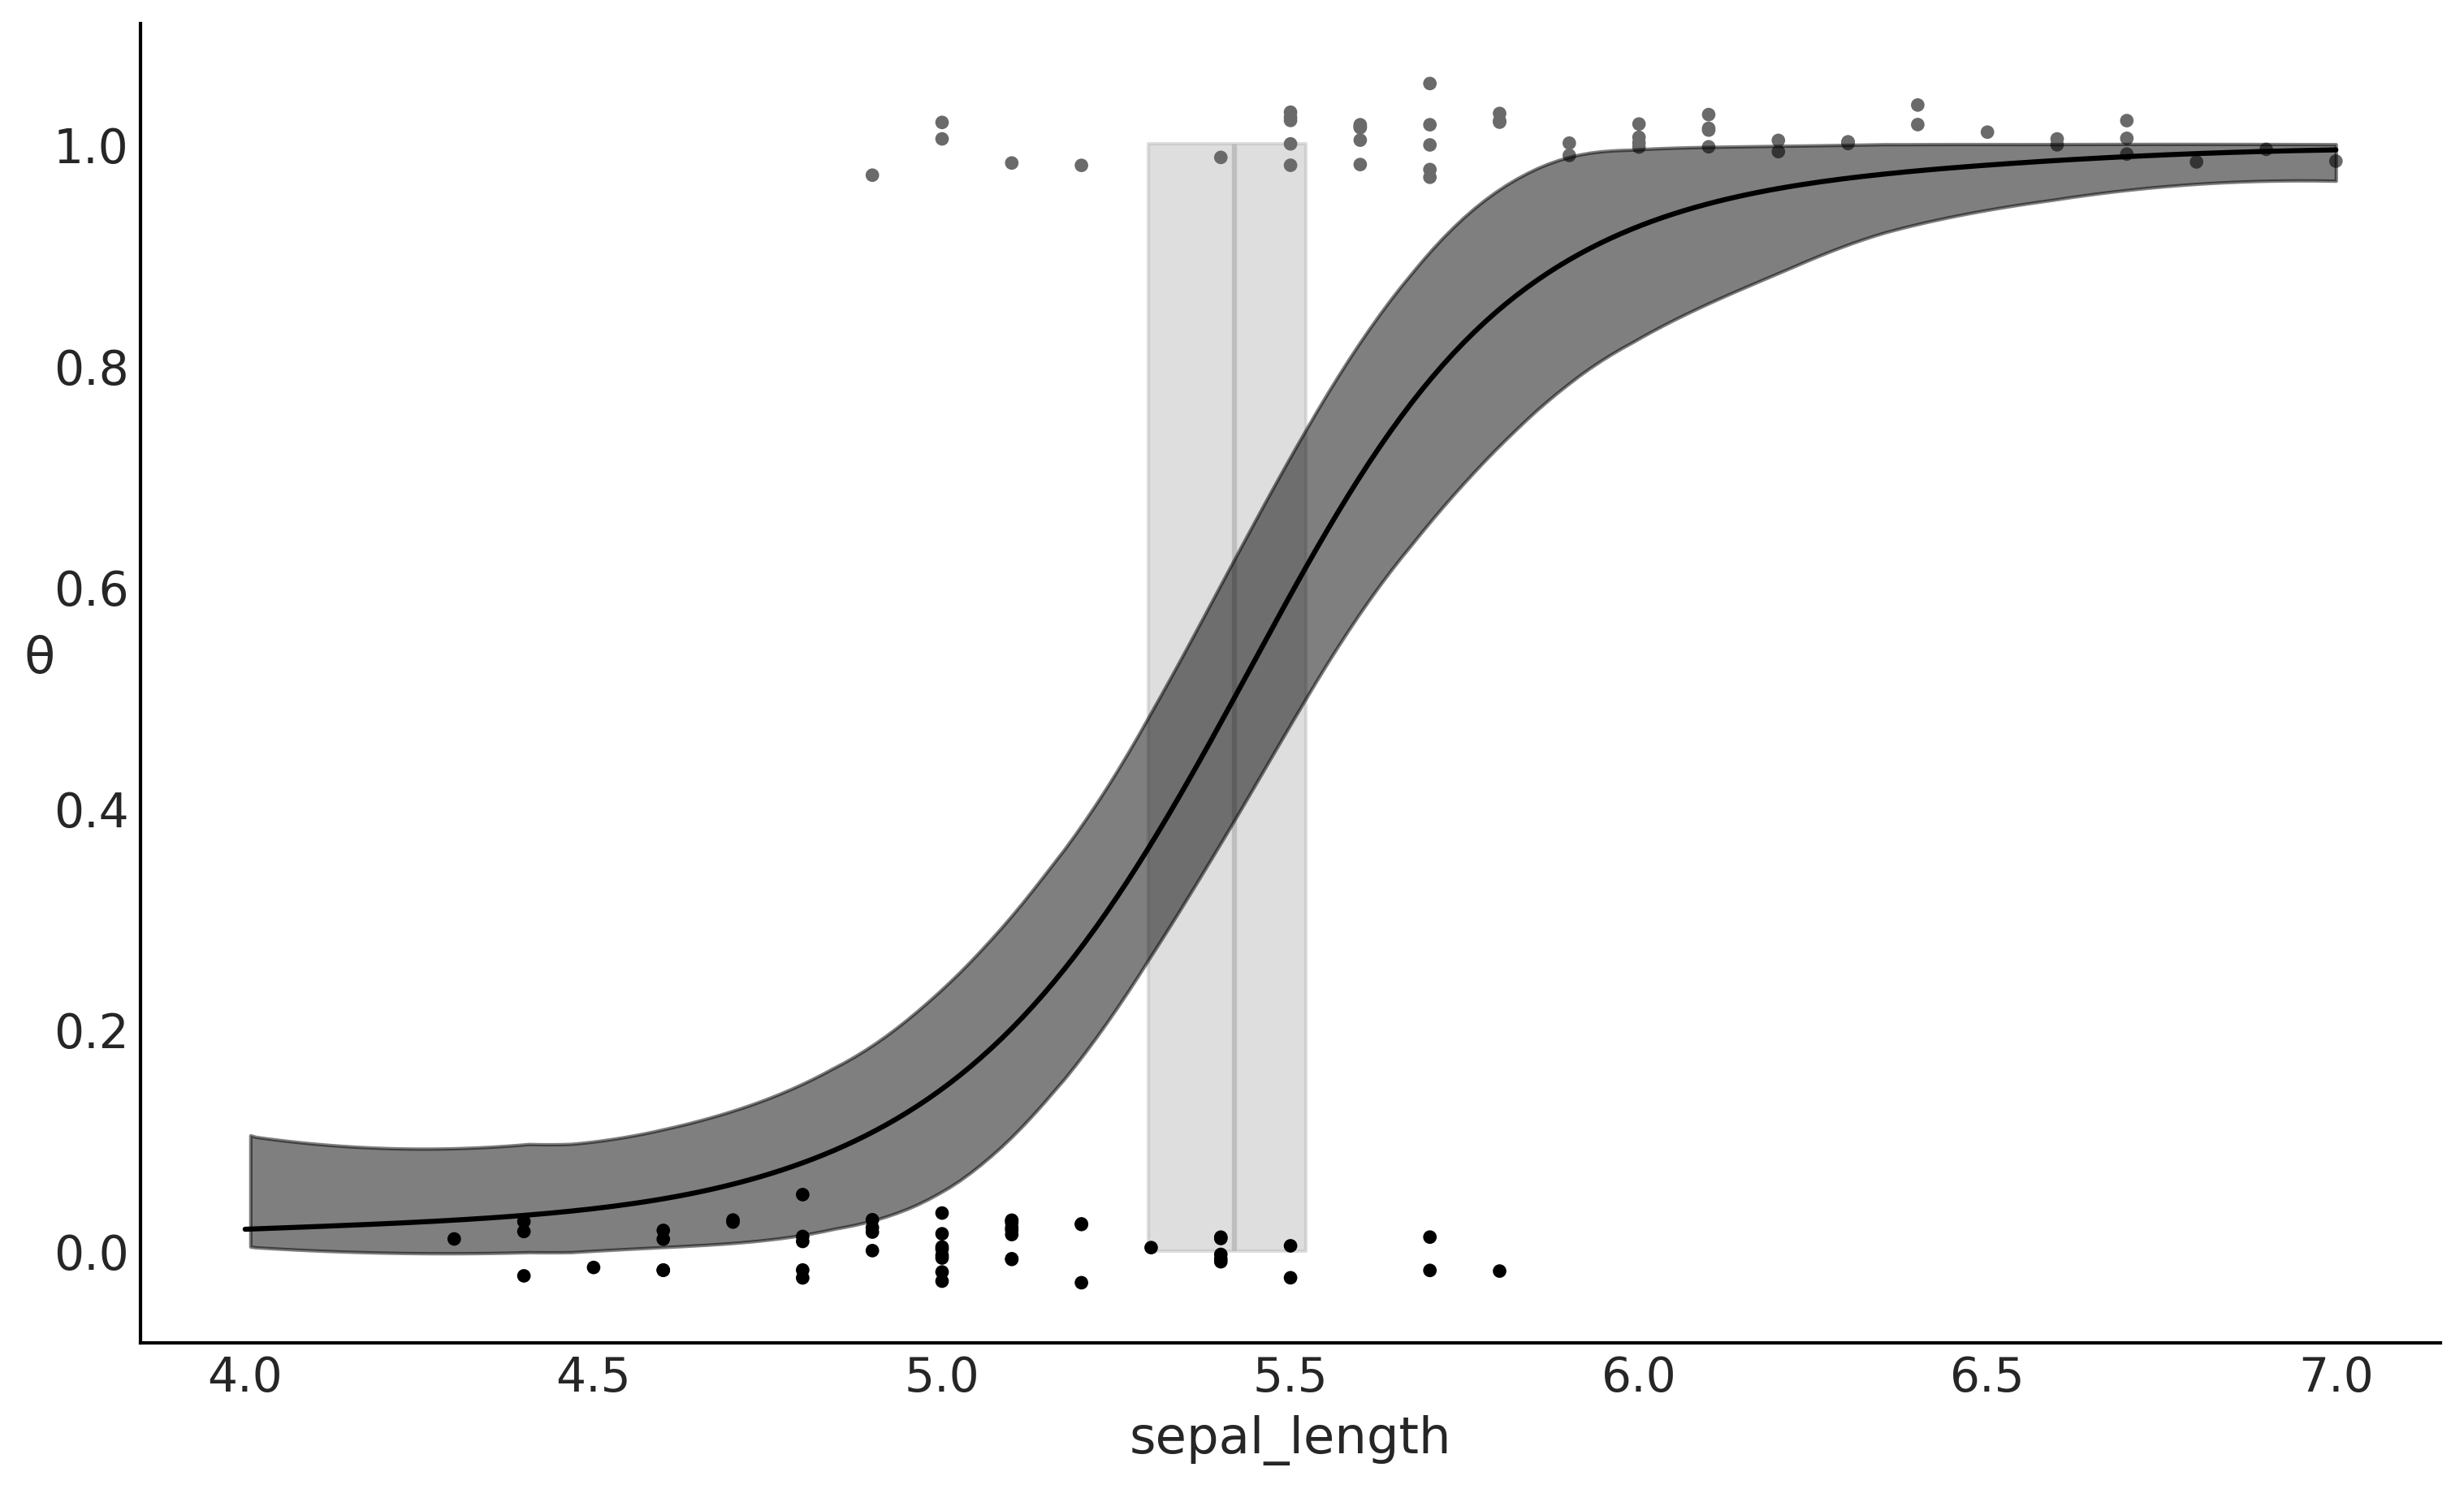

In [22]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_iris2)
fp_mean = np.mean(fp, 1)

ax.plot(X_new[:, 0], fp_mean)
# plot the data (with some jitter) and the true latent function
ax.scatter(x_1, np.random.normal(y, 0.02),
           marker='.', color=[f'C{x}' for x in y])

az.plot_hdi(X_new[:, 0], fp.T, color='C0')

decision_boundary = 0.5
db = X_new[:,0][np.argmin(np.abs(fp - decision_boundary), 0)]
db_mean = db.mean()
db_hdi = az.hdi(db)
ax.vlines(db_mean, 0, 1, color='C2', zorder=-1)
ax.fill_betweenx([0, 1], db_hdi[0], db_hdi[1], color='C2', alpha=0.5, zorder=-1)
ax.set_xlabel('sepal_length')
ax.set_ylabel('θ', rotation=0)
plt.savefig('../fig/GP_logistic_regression2.png')

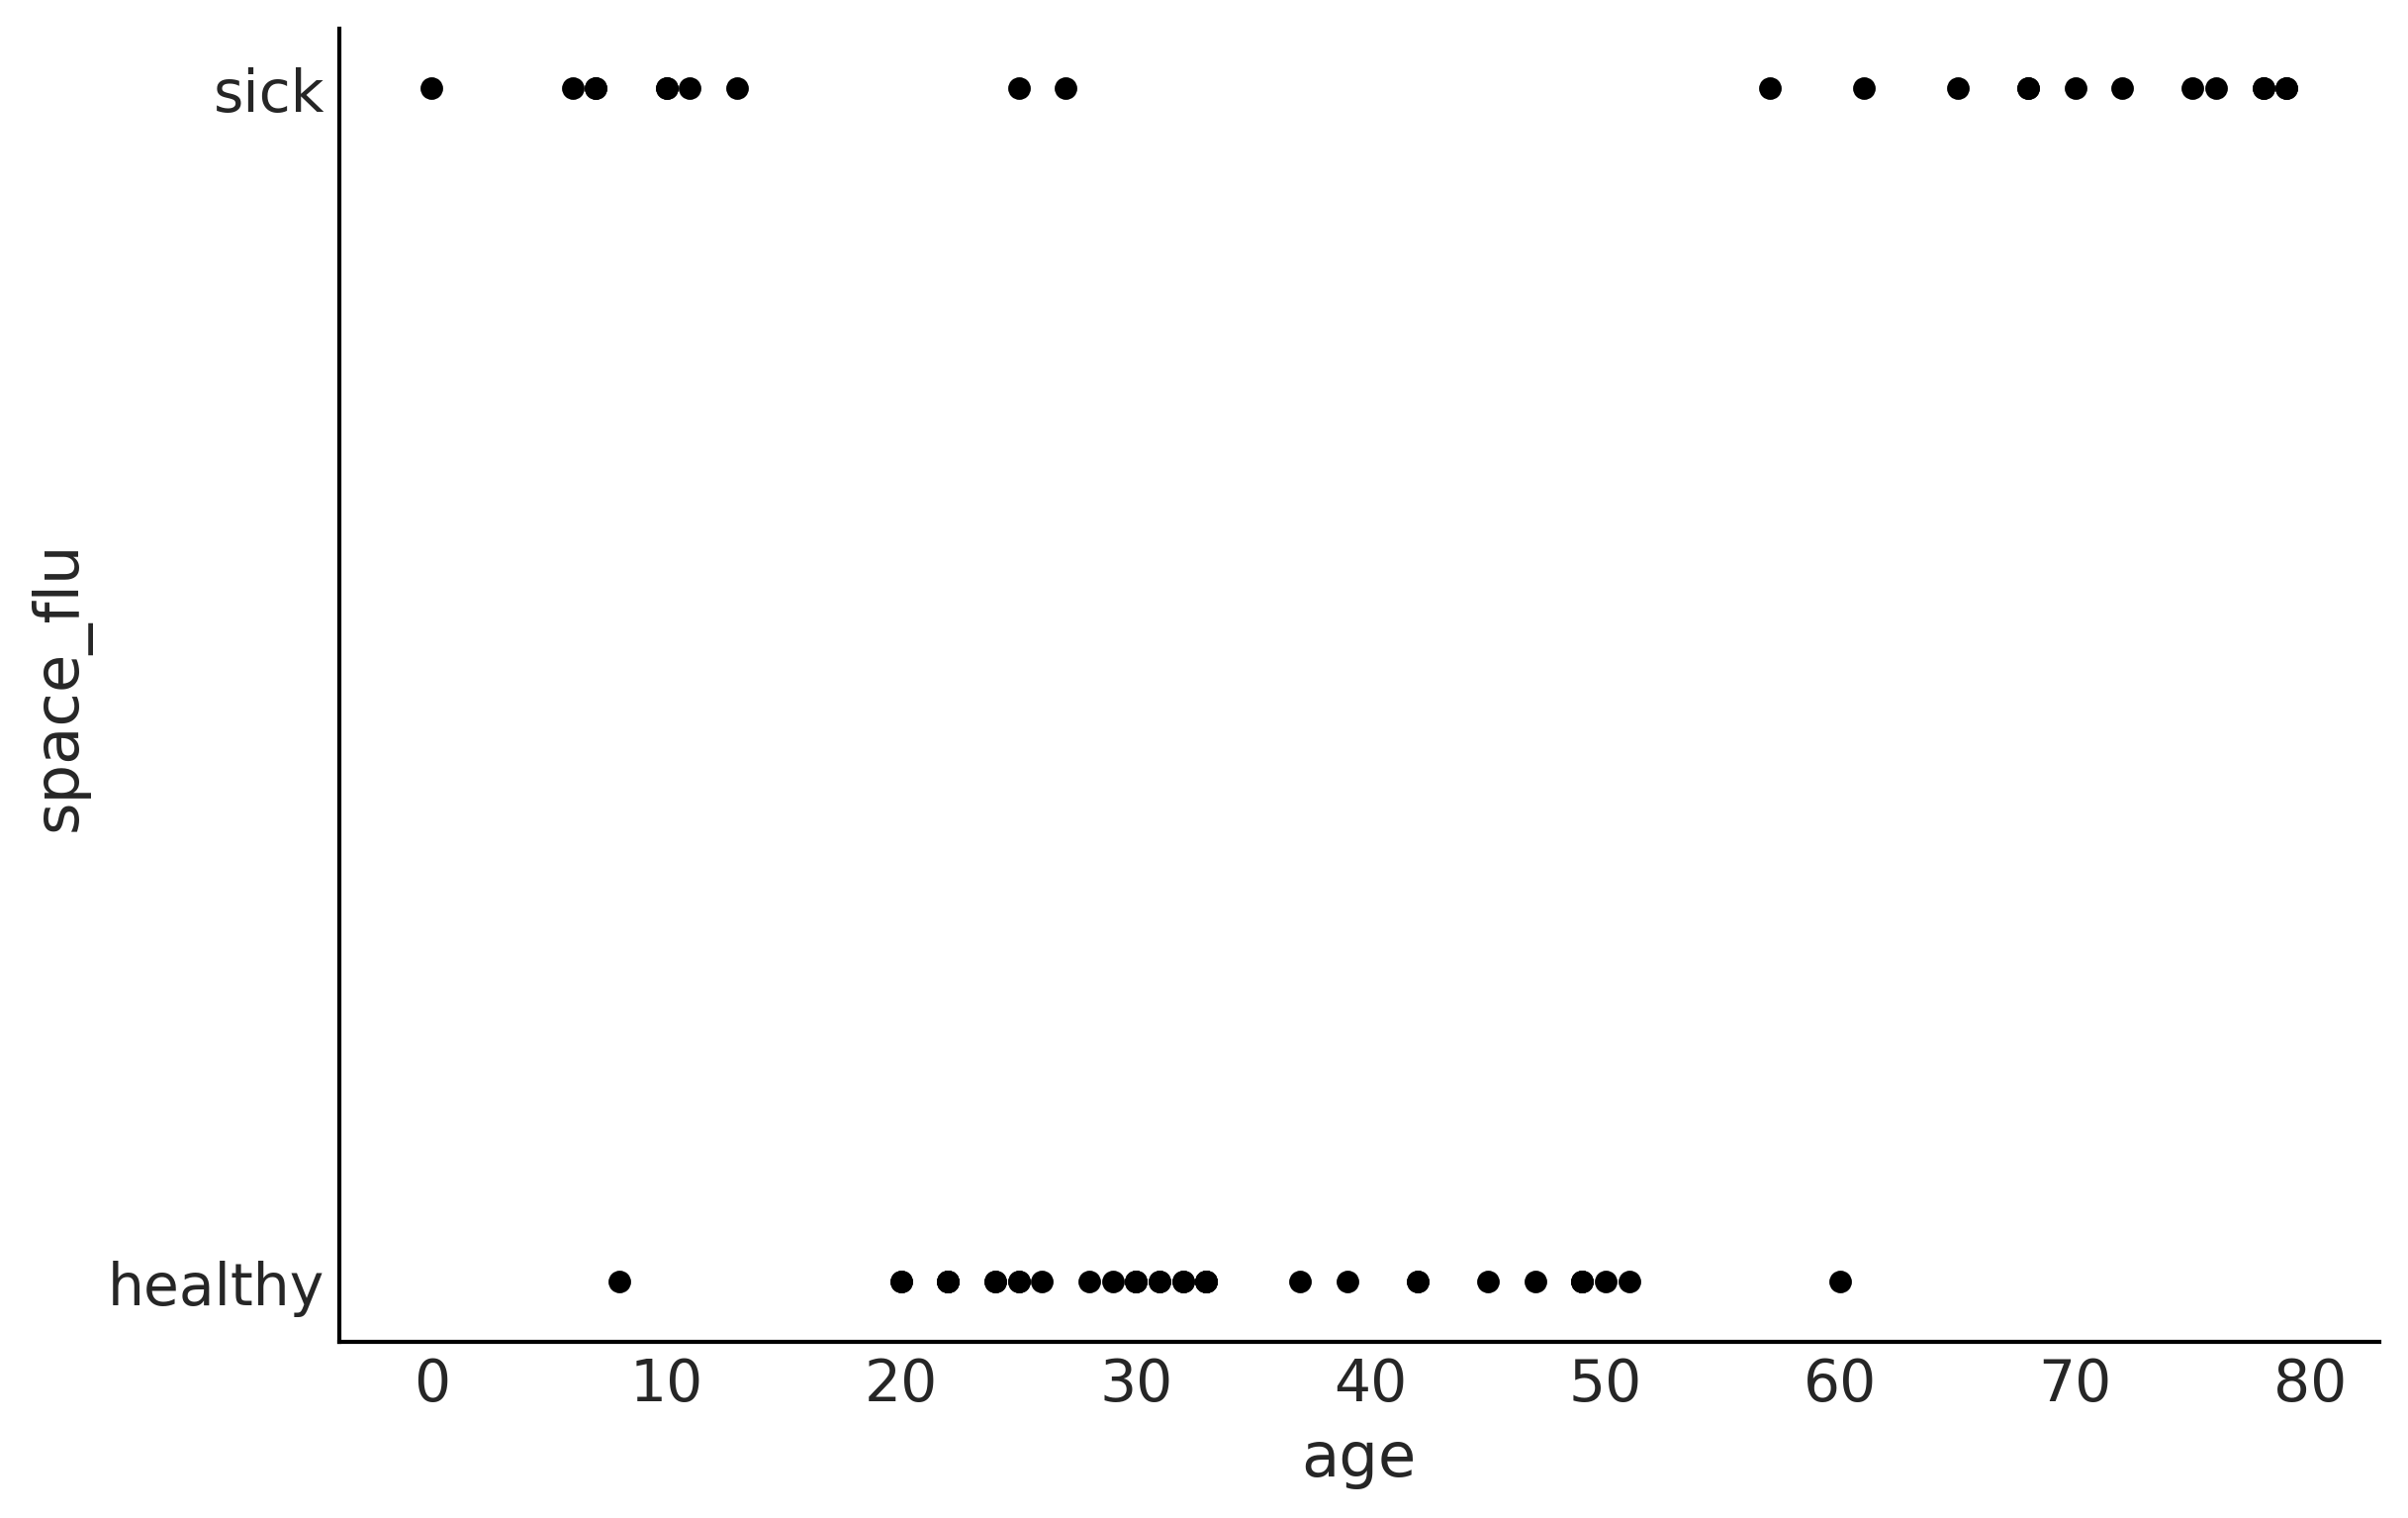

In [23]:
df_sf = pd.read_csv('data/space_flu.csv')
age = df_sf.age.values[:, None]
space_flu = df_sf.space_flu

ax = df_sf.plot.scatter('age', 'space_flu', figsize=(8, 5))
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
plt.savefig('../fig/space_flu.png', bbox_inches='tight')

In [24]:
with pm.Model() as model_space_flu:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(age))
    cov = pm.gp.cov.ExpQuad(1, ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=age)
    y_ = pm.Bernoulli('y', p=pm.math.sigmoid(f), observed=space_flu)
    idata_space_flu = pm.sample(nuts_sampler="nutpie", random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run SolveTriangular{trans=0, unit_diagonal=False, lower=False, check_finite=True, b_ndim=2}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:

In [25]:
X_new = np.linspace(0, 80, 200)[:, None]

    
with model_space_flu:
    f_pred = gp.conditional('f_pred', X_new) 
    idata_space_flu_subset = idata_space_flu.sel(draw=slice(0, None, 100))
    pred_samples_flu = pm.sample_posterior_predictive(idata_space_flu_subset, var_names=["f_pred"], random_seed=123)


f_pred_space_flu = (pred_samples_flu.
                    posterior_predictive.stack(samples=("chain", "draw"))['f_pred'].
                    values)

Sampling: [f_pred]


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


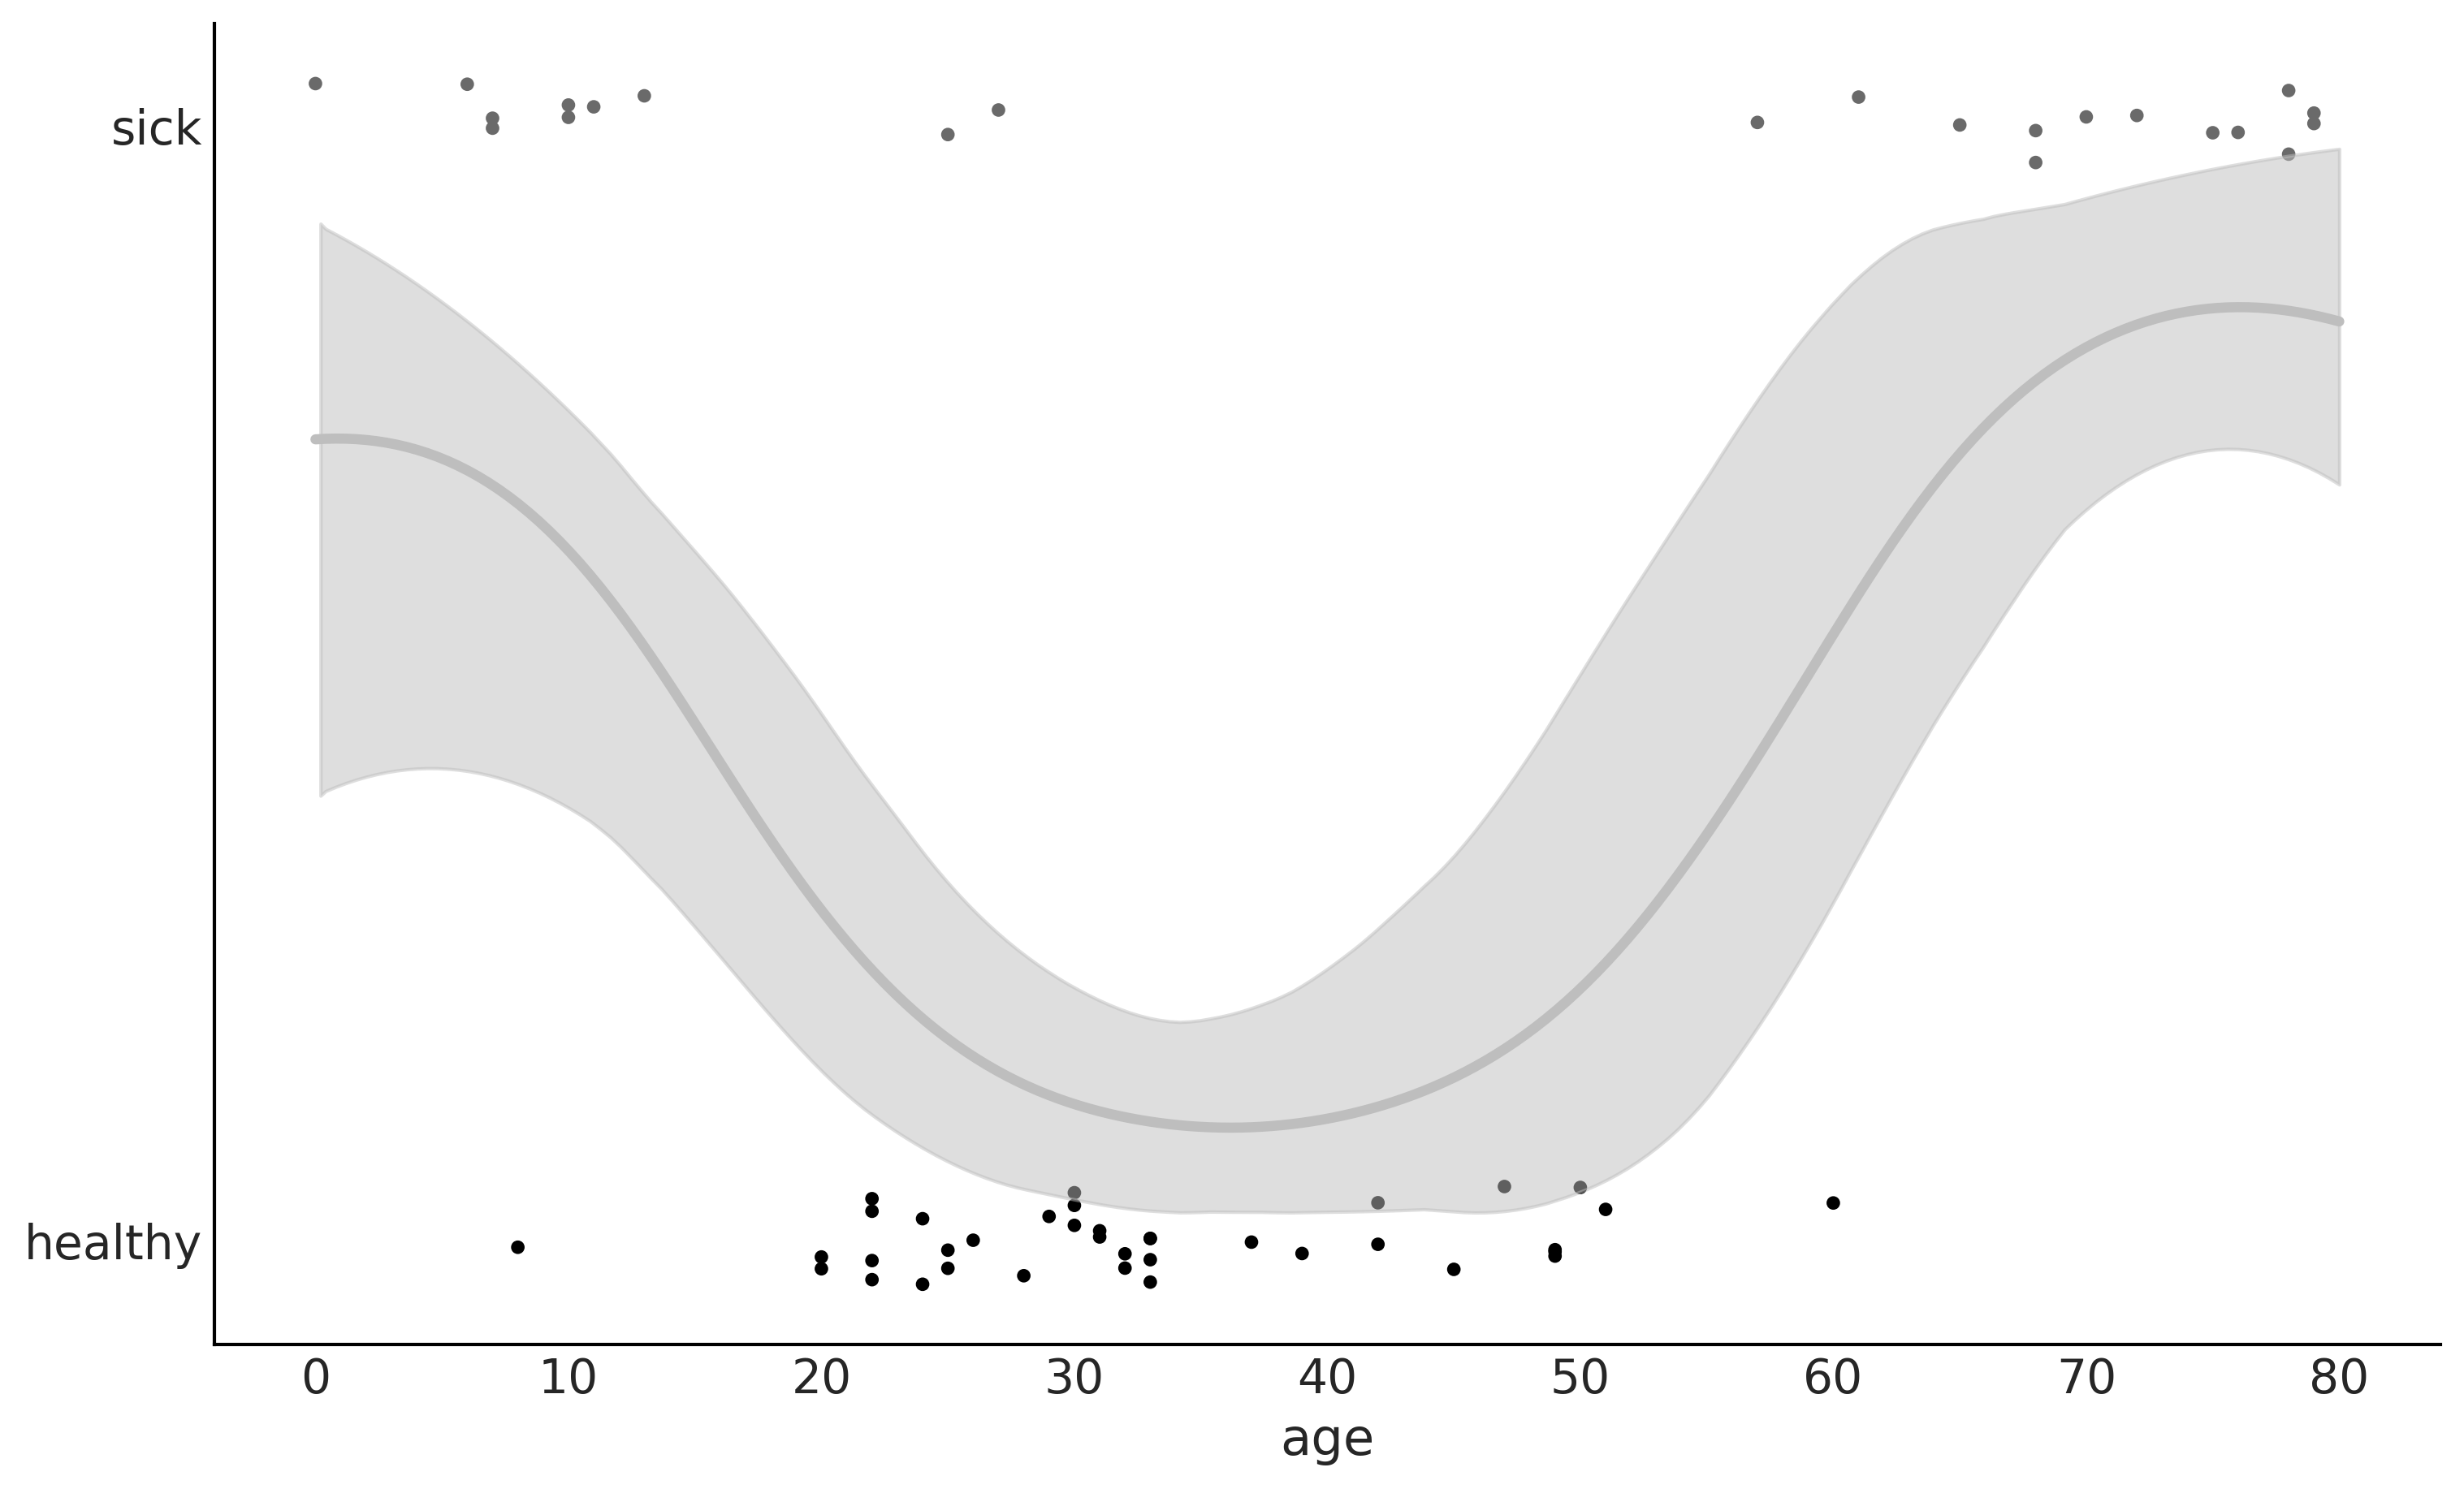

In [26]:
_, ax = plt.subplots(figsize=(10, 6))

fp = logistic(f_pred_space_flu)
fp_mean = np.nanmean(fp, 1)

ax.scatter(age, np.random.normal(space_flu, 0.02),
           marker='.', color=[f'C{ci}' for ci in space_flu])

ax.plot(X_new[:, 0], fp_mean, 'C2', lw=3)

az.plot_hdi(X_new[:, 0], fp.T, color='C2', smooth=True)
ax.set_yticks([0, 1])
ax.set_yticklabels(['healthy', 'sick'])
ax.set_xlabel('age')
plt.savefig('../fig/GP_space_flu.png')


### the coal-mining disaster

In [27]:
coal_df = pd.read_csv('data/coal.csv', header=None)
coal_df.head()

0
0  1851.2026
1  1851.6324
2  1851.9692
3  1851.9747
4  1852.3142

In [28]:
# discretize data
years = int((coal_df.max() - coal_df.min()).iloc[0])
bins = years // 4
hist, x_edges = np.histogram(coal_df, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist

In [29]:
with pm.Model() as model_coal:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_edges))
    cov = pm.gp.cov.ExpQuad(1, ls=ℓ) + pm.gp.cov.WhiteNoise(1E-5)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=x_data)

    y_pred = pm.Poisson('y_pred', mu=pm.math.exp(f), observed=y_data)
    idata_coal = pm.sample(nuts_sampler="nutpie", random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run SolveTriangular{trans=0, unit_diagonal=False, lower=False, check_finite=True, b_ndim=2}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


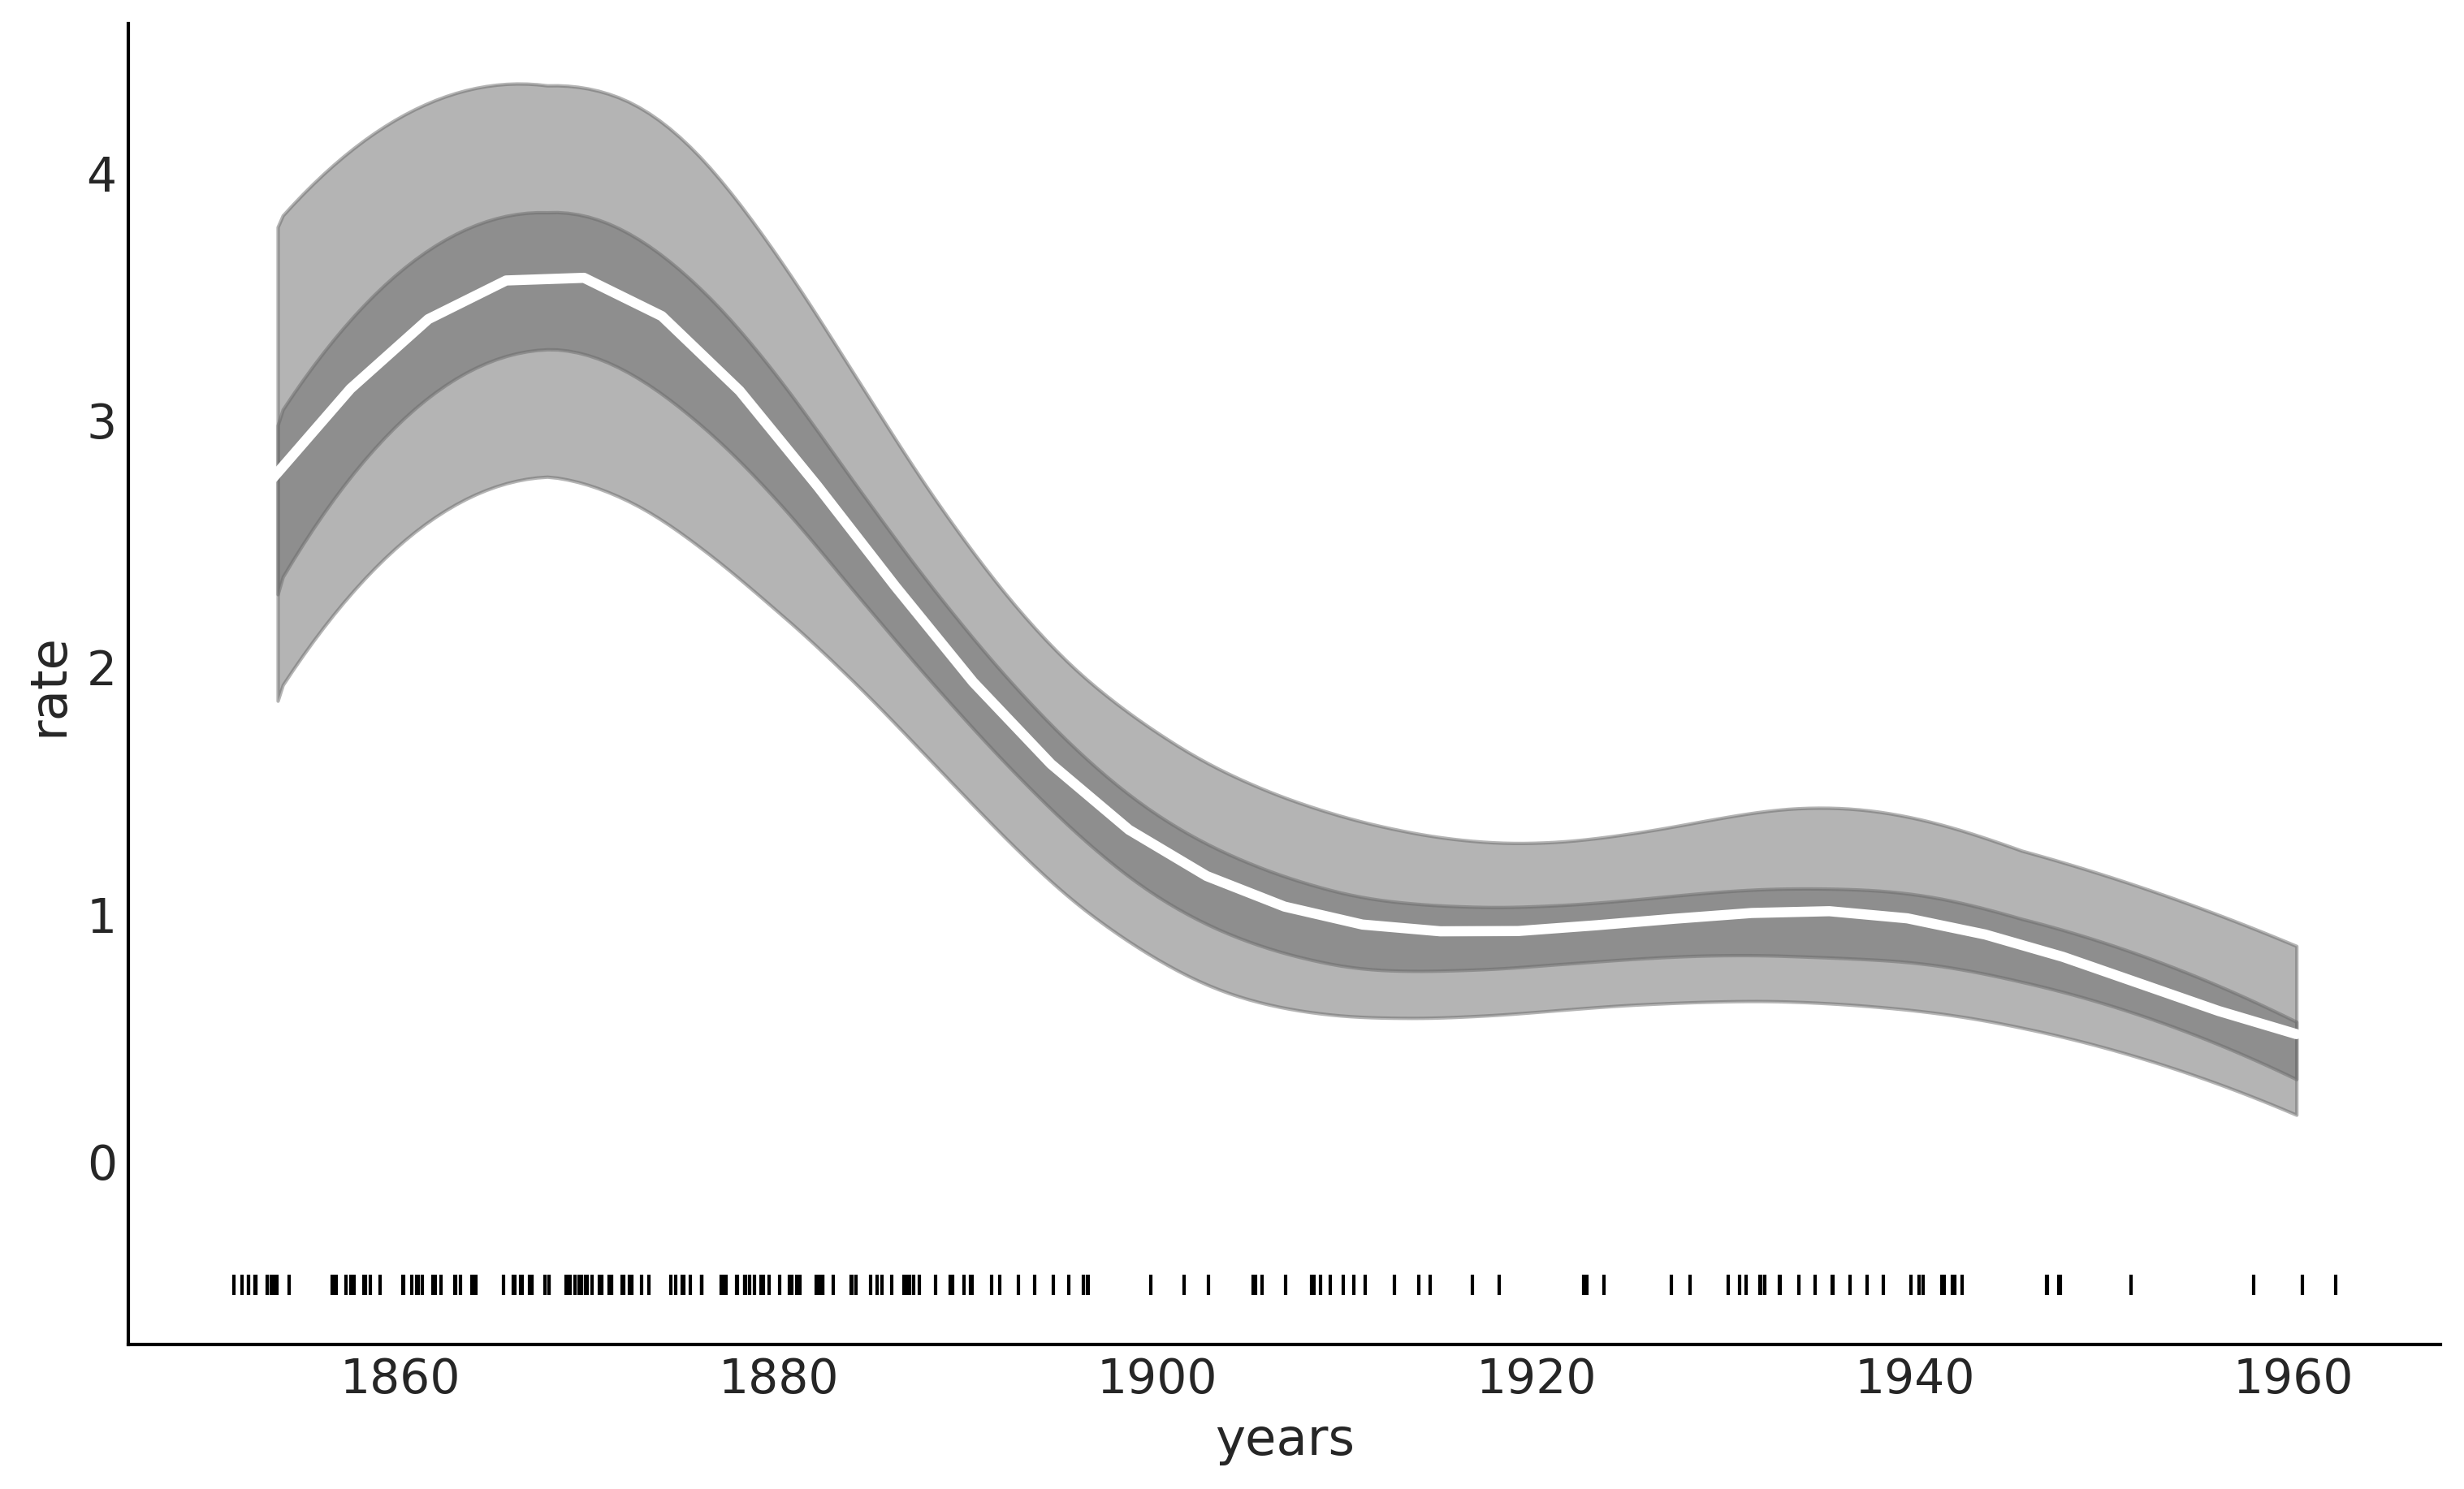

In [30]:
_, ax = plt.subplots(figsize=(10, 6))

f_trace = np.exp(idata_coal.posterior['f'].stack(samples=("chain", "draw")).T) / 4
rate_median = np.median(f_trace, axis=0)

ax.plot(x_centers, rate_median, 'w', lw=3)
az.plot_hdi(x_centers, f_trace)

az.plot_hdi(x_centers, f_trace, hdi_prob=0.5,
            plot_kwargs={'alpha': 0})

ax.plot(coal_df, np.zeros_like(coal_df)-0.5, 'k|')
ax.set_xlabel('years')
ax.set_ylabel('rate')
plt.savefig('../fig/coal_mining.png')

### the redwood data

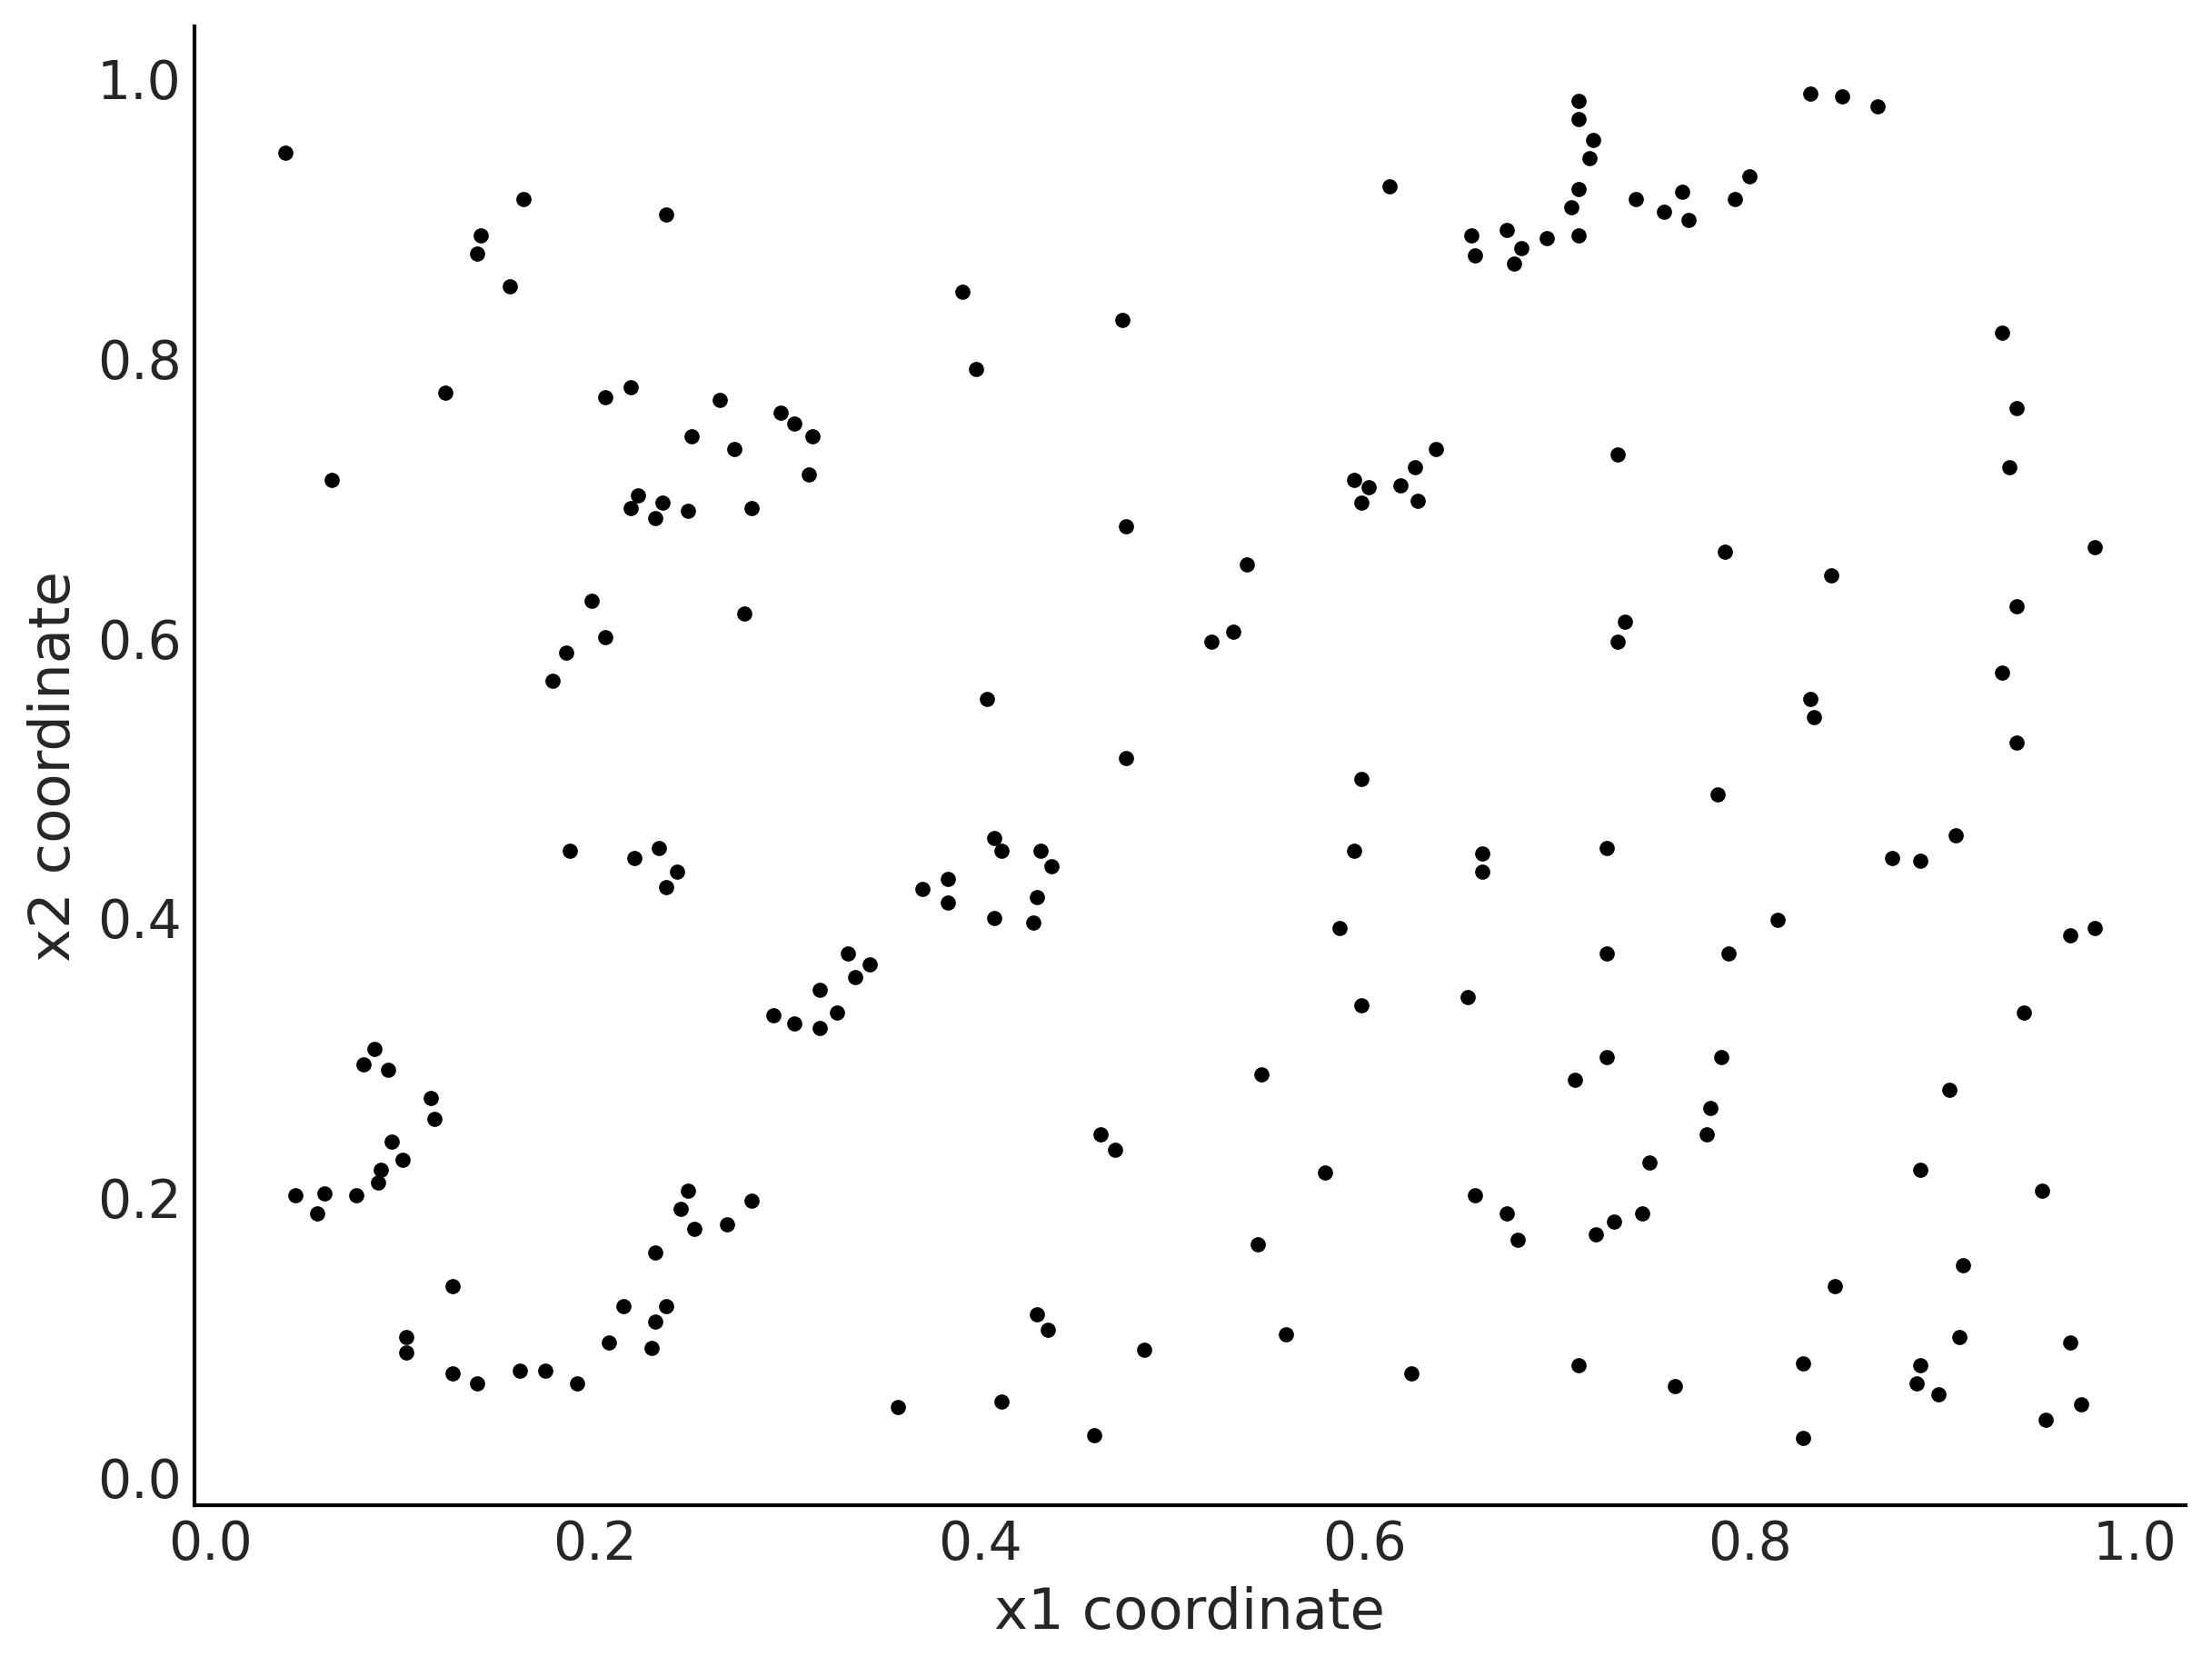

In [31]:
rw_df = pd.read_csv('data/redwood.csv', header=None)
_, ax = plt.subplots(figsize=(8, 6))
ax.plot(rw_df[0], rw_df[1], 'C0.')
ax.set_xlabel('x1 coordinate')
ax.set_ylabel('x2 coordinate')
plt.savefig('../fig/redwood.png')

In [32]:
# discretize spatial data
bins = 20
hist, x1_edges, x2_edges = np.histogram2d(
    rw_df[1].values, rw_df[0].values, bins=bins)
# compute the location of the centers of the discretized data
x1_centers = x1_edges[:-1] + (x1_edges[1] - x1_edges[0]) / 2
x2_centers = x2_edges[:-1] + (x2_edges[1] - x2_edges[0]) / 2
# arrange xdata into proper shape for GP
x_data = [x1_centers[:, None], x2_centers[:, None]]
# arrange ydata into proper shape for GP
y_data = hist.flatten().astype(int)

In [33]:
with pm.Model() as model_rw:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(x_data), shape=2)
    cov_func1 = pm.gp.cov.ExpQuad(1, ls=ℓ[0])
    cov_func2 = pm.gp.cov.ExpQuad(1, ls=ℓ[1])

    gp = pm.gp.LatentKron(cov_funcs=[cov_func1, cov_func2])
    f = gp.prior('f', Xs=x_data)

    y = pm.Poisson('y', mu=pm.math.exp(f), observed=y_data)
    idata_rw = pm.sample(nuts_sampler="nutpie", random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run SolveTriangular

In [34]:
az.summary(idata_rw, var_names=['ℓ'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ℓ[0]  0.143  0.038   0.091    0.208      0.003    0.002     227.0     344.0   
ℓ[1]  0.112  0.023   0.071    0.156      0.001    0.001     269.0     496.0   

      r_hat  
ℓ[0]   1.01  
ℓ[1]   1.02

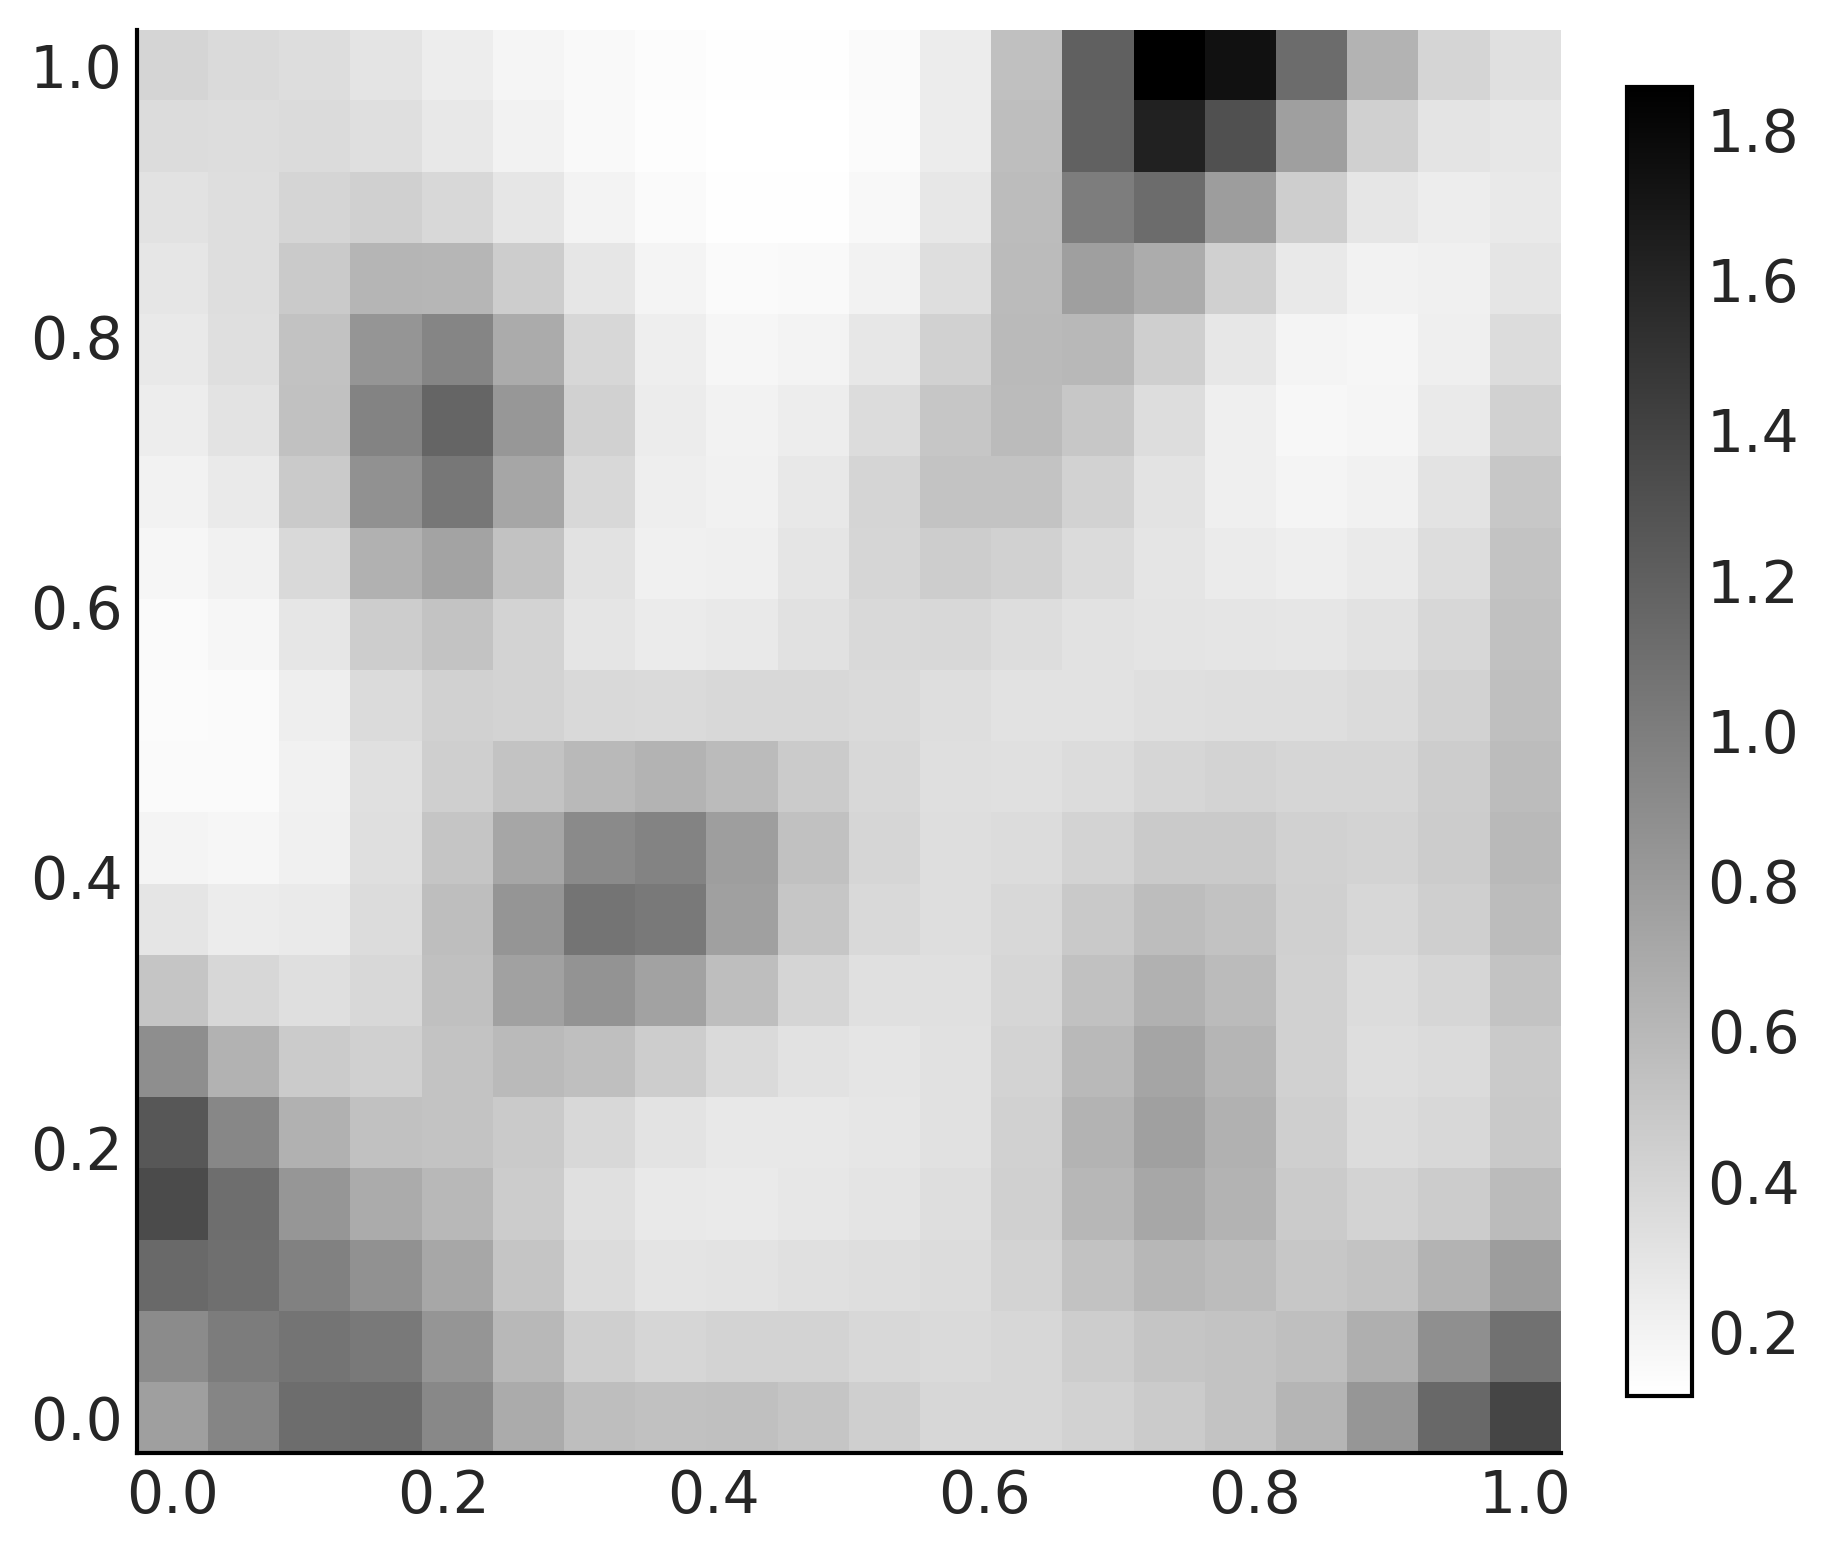

In [35]:
rate = np.exp(np.mean(idata_rw.posterior['f'].stack(samples=("chain", "draw")).T, axis=0).values.reshape((bins, -1)))
fig, ax = plt.subplots(figsize=(6, 6))
ims = ax.imshow(rate, origin='lower', cmap='gray_r')

ax.grid(False)
ticks_loc = np.linspace(0, bins-1, 6)
ticks_lab = np.linspace(0, 1, 6).round(1)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(ticks_lab)
ax.set_yticklabels(ticks_lab)
ax.axis('square')
cbar = fig.colorbar(ims, fraction=0.046, pad=0.04)

plt.savefig('../fig/GP_redwood.png')

## Regression with spatial autocorrelation

In [36]:
islands = pd.read_csv('data/islands.csv')
islands.head().round(1)
X = islands[["lat", "lon"]].values

In [37]:
def haversine_distance(lat, lon, r=6.371):

    lat = np.radians(lat)
    lon = np.radians(lon)
    
    latd = lat[:,None] - lat
    lond = lon[:,None] - lon

    d = np.cos(lat[:,None]) * np.cos(lat)
    a = np.sin(latd / 2)** 2 + d * np.sin(lond / 2)** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return r * c

islands_dist = haversine_distance(X[:,0], X[:,1])

In [38]:
class ExpQuadHaversine(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, ls_inv=None, r=6.371, active_dims=None):
        super().__init__(input_dims, ls=ls,  ls_inv=ls_inv, active_dims=active_dims)
        self.r = r # earth radius in thousands of km

    def haversine_distance(self, X):

        lat = np.radians(X[:, 0])
        lon = np.radians(X[:, 1])

        latd = lat[:,None] - lat
        lond = lon[:,None] - lon

        d = pt.cos(lat[:,None]) * pt.cos(lat)
        a = pt.sin(latd / 2)** 2 + d * pt.sin(lond / 2)** 2
        c = 2 * pt.arctan2(pt.sqrt(a), pt.sqrt(1 - a))

        return self.r * c

    def full(self, X, _):
        return pt.exp(-0.5 * self.haversine_distance(X))

In [39]:
culture_labels = islands.culture.values
index = islands.index.values
log_pop = islands.logpop
total_tools = islands.total_tools
x_data = [islands.lat.values[:, None], islands.lon.values[:, None]]

In [40]:
with pm.Model() as model_islands:
    η = pm.Exponential('η', 2)
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(islands_dist))
    
    cov = η * ExpQuadHaversine(2, ls=ℓ)
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior('f', X=X)

    α = pm.Normal('α', 0, 5)
    β = pm.Normal('β', 0, 1)
    μ = pm.math.exp(α + β * log_pop + f)
    _ = pm.Poisson('tt_pred', μ, observed=total_tools)
    idata_islands = pm.sample(nuts_sampler="nutpie", target_accept=0.9, random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run Tri{dtype='float64'}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run SolveTriangular{trans=0, unit_diagonal=False, lower=False, check_finite=True, b_ndim=2}'s perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:373: UserWarning: Numba will use object mode to run AdvancedSetSubtensor's perform method
  warnings.warn(
/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/pytensor/link/numba/dispatch/basic.py:

In [41]:
az.summary(idata_islands, var_names=['η', 'ℓ', 'α', 'β'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
η  0.200  0.162   0.015    0.483      0.006    0.004     822.0    1302.0   
ℓ  2.190  1.471   0.610    4.468      0.034    0.031    4673.0    2075.0   
α  1.232  1.060  -0.837    3.252      0.049    0.036     440.0     609.0   
β  0.253  0.106   0.055    0.459      0.005    0.004     445.0     626.0   

   r_hat  
η   1.00  
ℓ   1.00  
α   1.01  
β   1.01

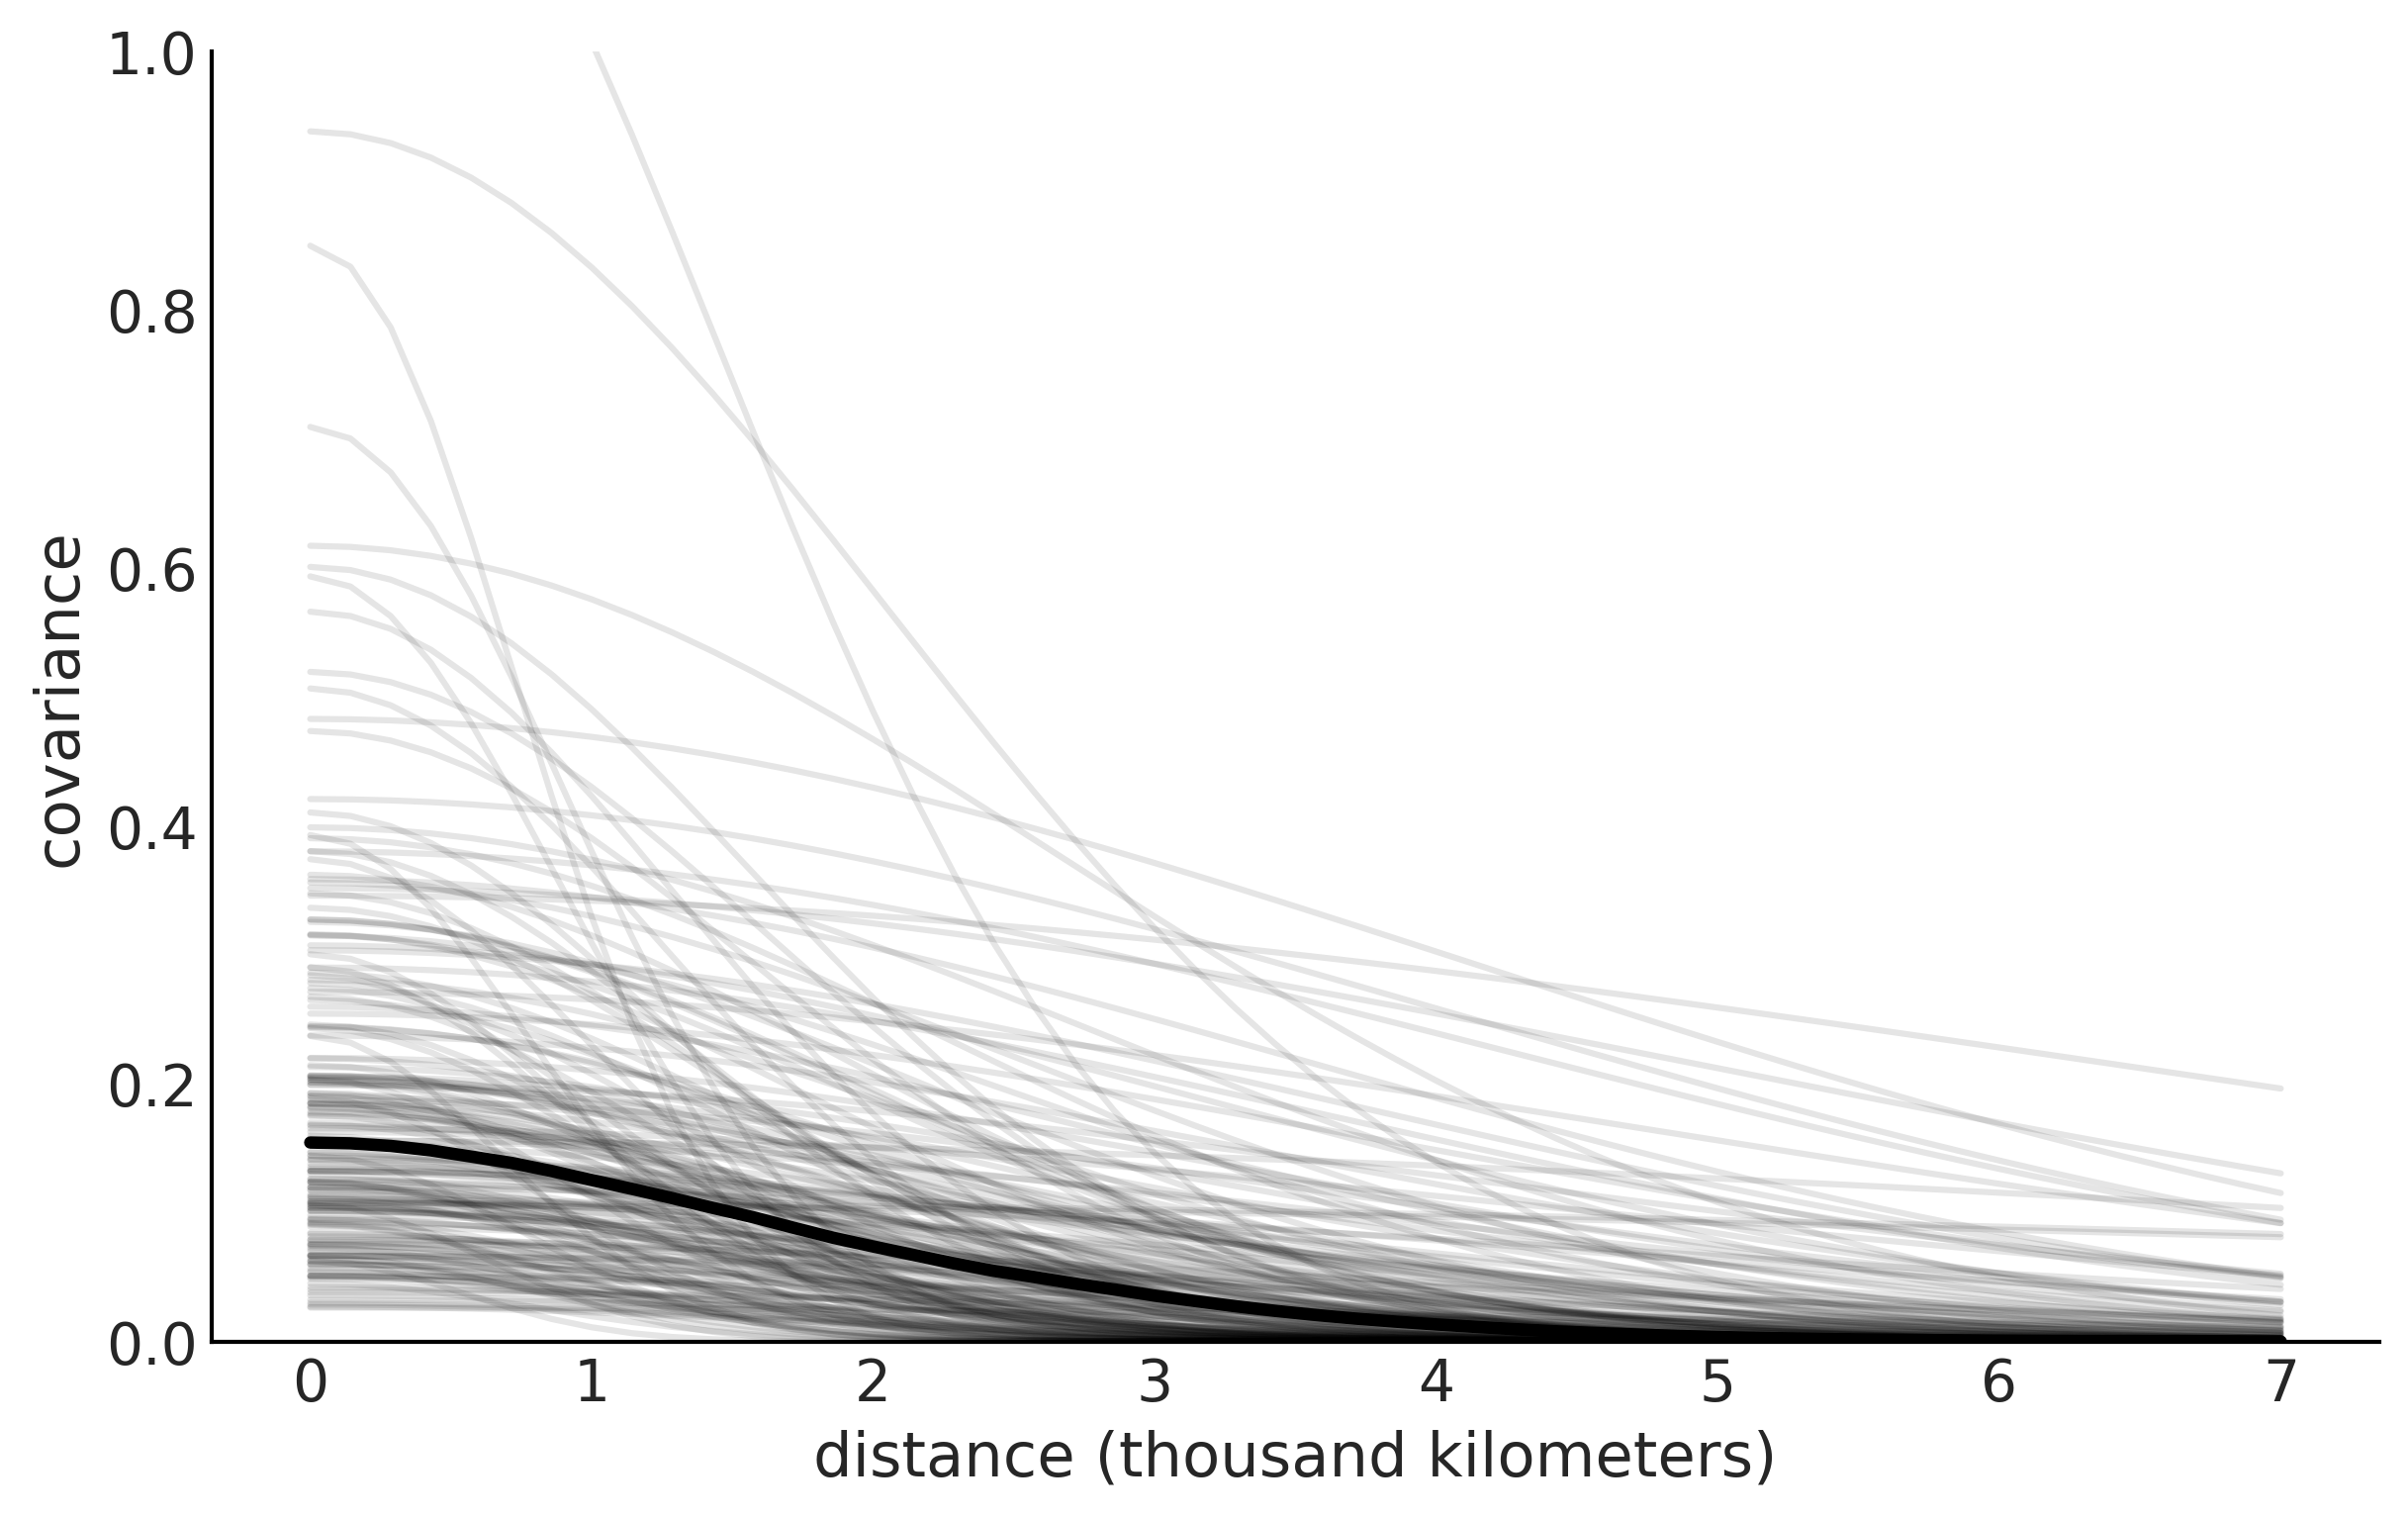

In [42]:
posterior_islands = idata_islands.posterior.stack(samples=("chain", "draw"))
trace_η = posterior_islands['η'].values
trace_ℓ = posterior_islands['ℓ'].values

_, ax = plt.subplots(1, 1, figsize=(8, 5))
xrange = np.linspace(0, 7)

median_ = np.median(trace_η[:,None] * (np.exp(-xrange**2 / (2*trace_ℓ[:,None]**2))), axis=0)

ax.plot(xrange, median_, lw=3)


ax.plot(xrange, (trace_η[::20][:, None] * np.exp(-xrange**2 / (2*trace_ℓ[::20][:, None]**2))).T,
        'C0', alpha=.1)

ax.set_ylim(0, 1)
ax.set_xlabel('distance (thousand kilometers)')
ax.set_ylabel('covariance')
plt.savefig('../fig/GP_islands_dist_cov.png')

In [43]:
# compute posterior median covariance among societies
Σ = np.median(trace_η) * (np.exp(-(islands_dist)**2 / (2*np.median(trace_ℓ)**2)))


# convert to correlation matrix
Σ_post = np.diag(np.diag(Σ)**-0.5)
ρ = Σ_post @  Σ @ Σ_post
ρ = pd.DataFrame(ρ, index=culture_labels, columns=culture_labels)

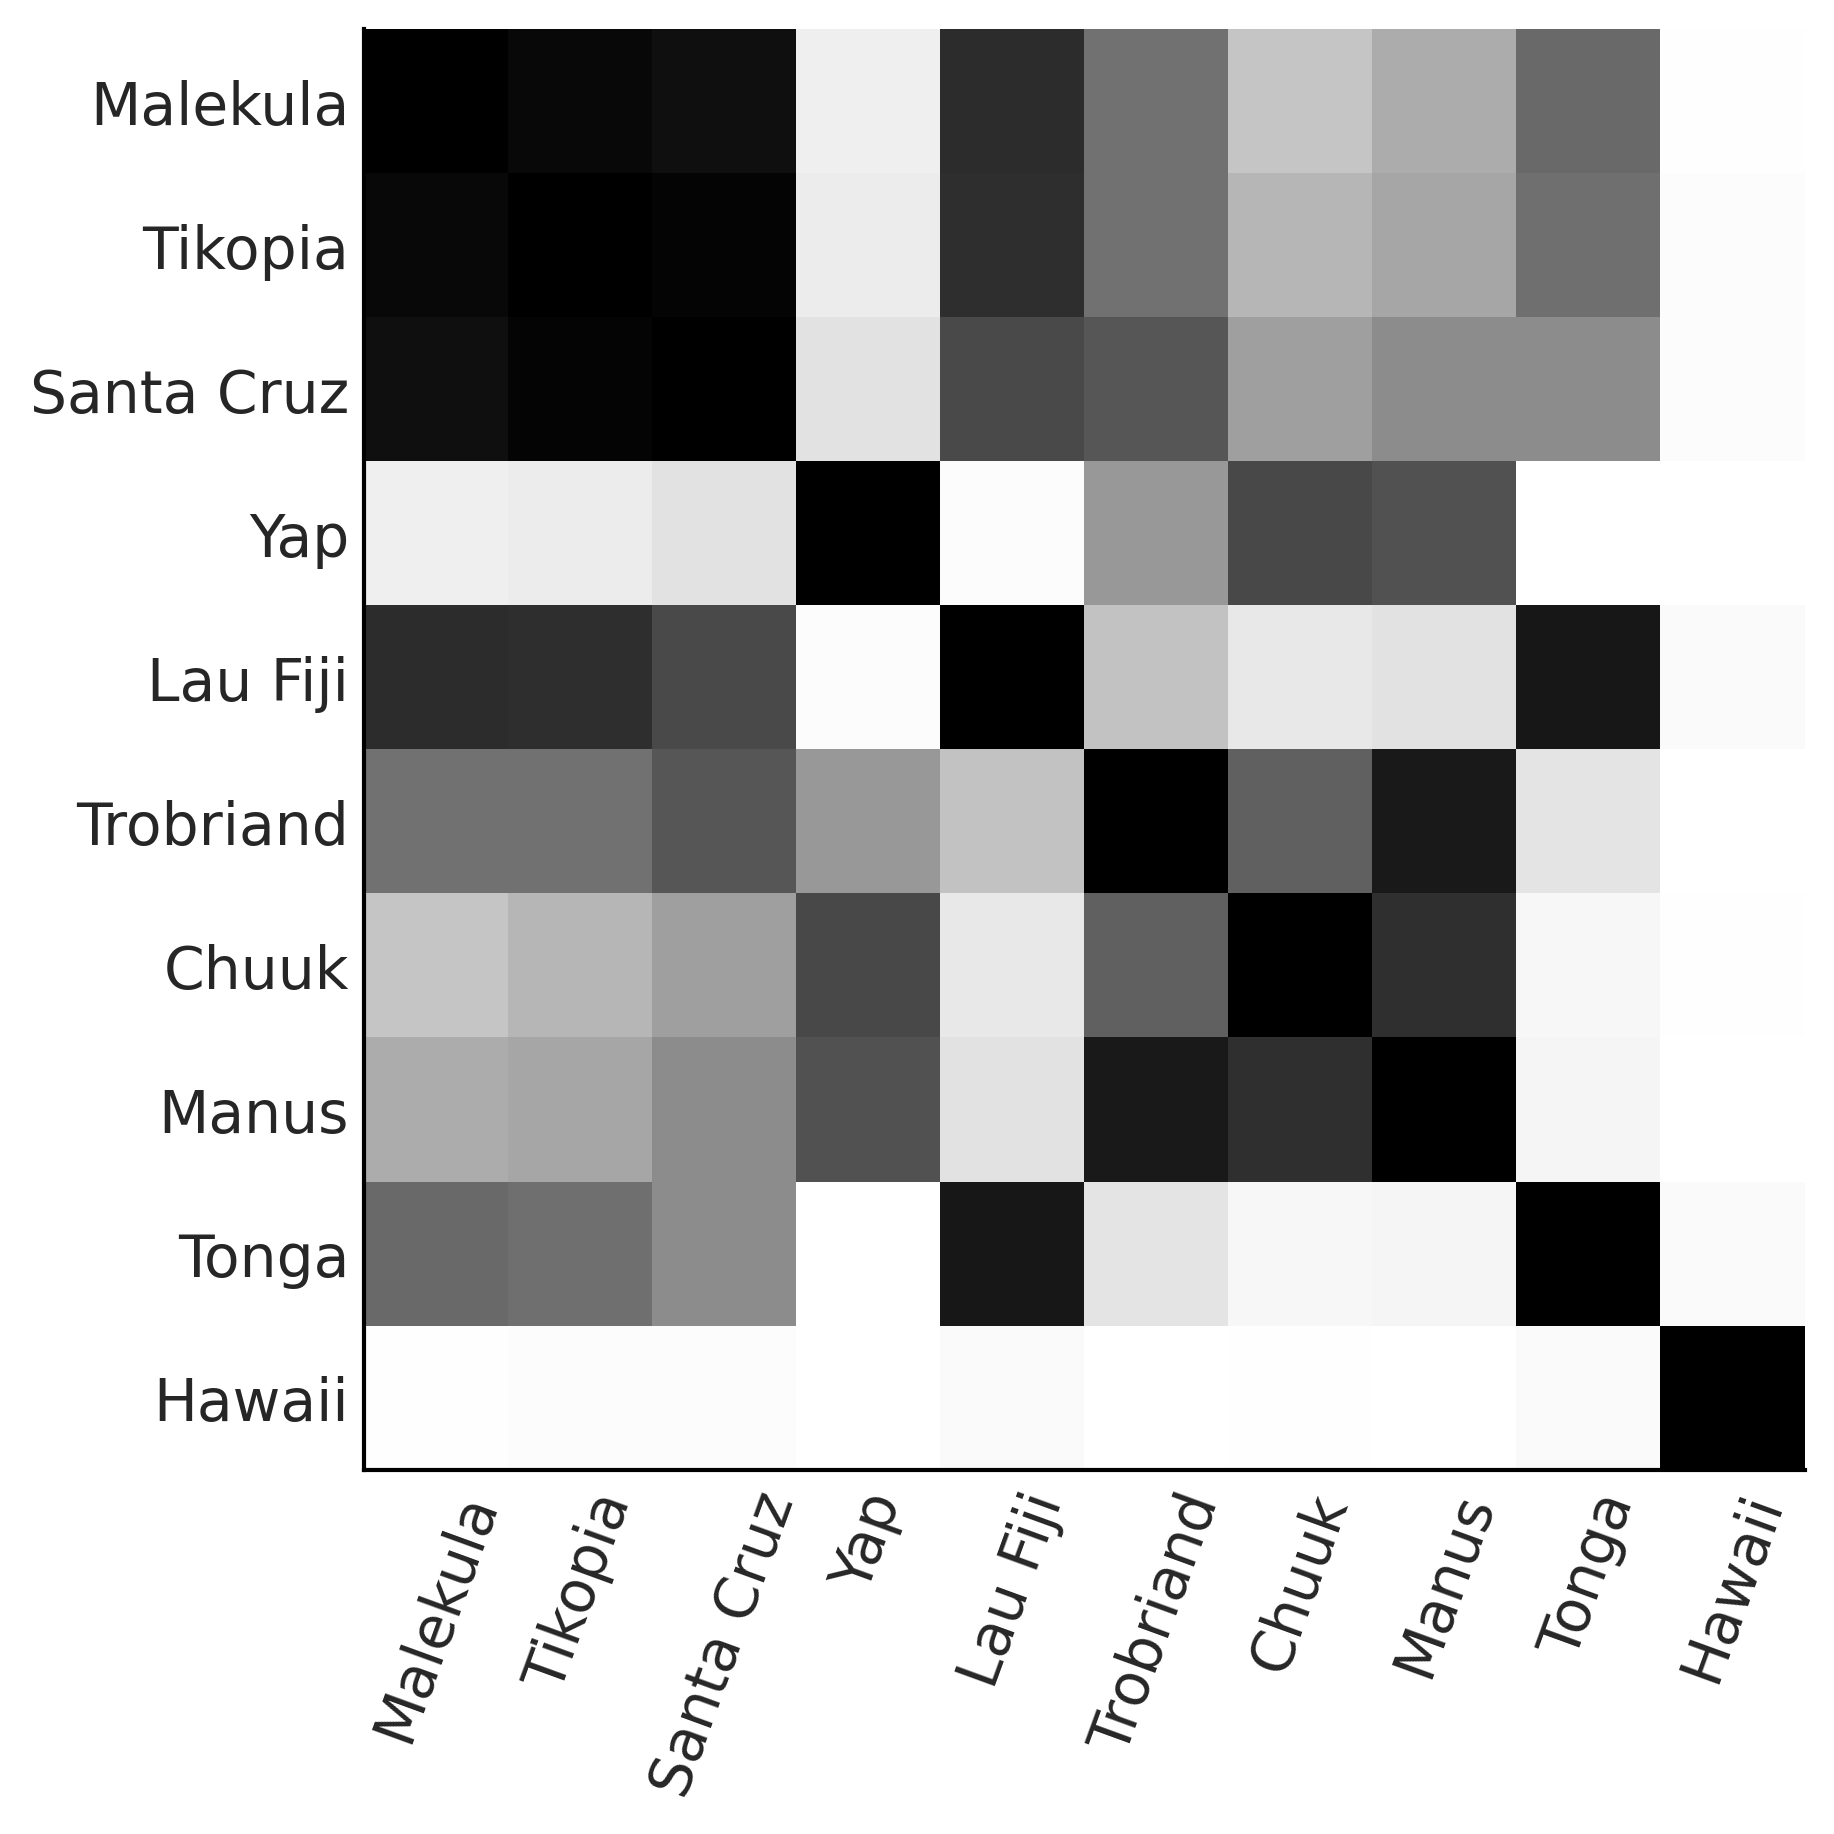

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(ρ, cmap='gray_r')

ticks_loc = np.arange(10)
ax.set_xticks(ticks_loc)
ax.set_yticks(ticks_loc)
ax.set_xticklabels(culture_labels, rotation=70)
ax.set_yticklabels(culture_labels)
plt.savefig('../fig/GP_islands_corr.png')

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


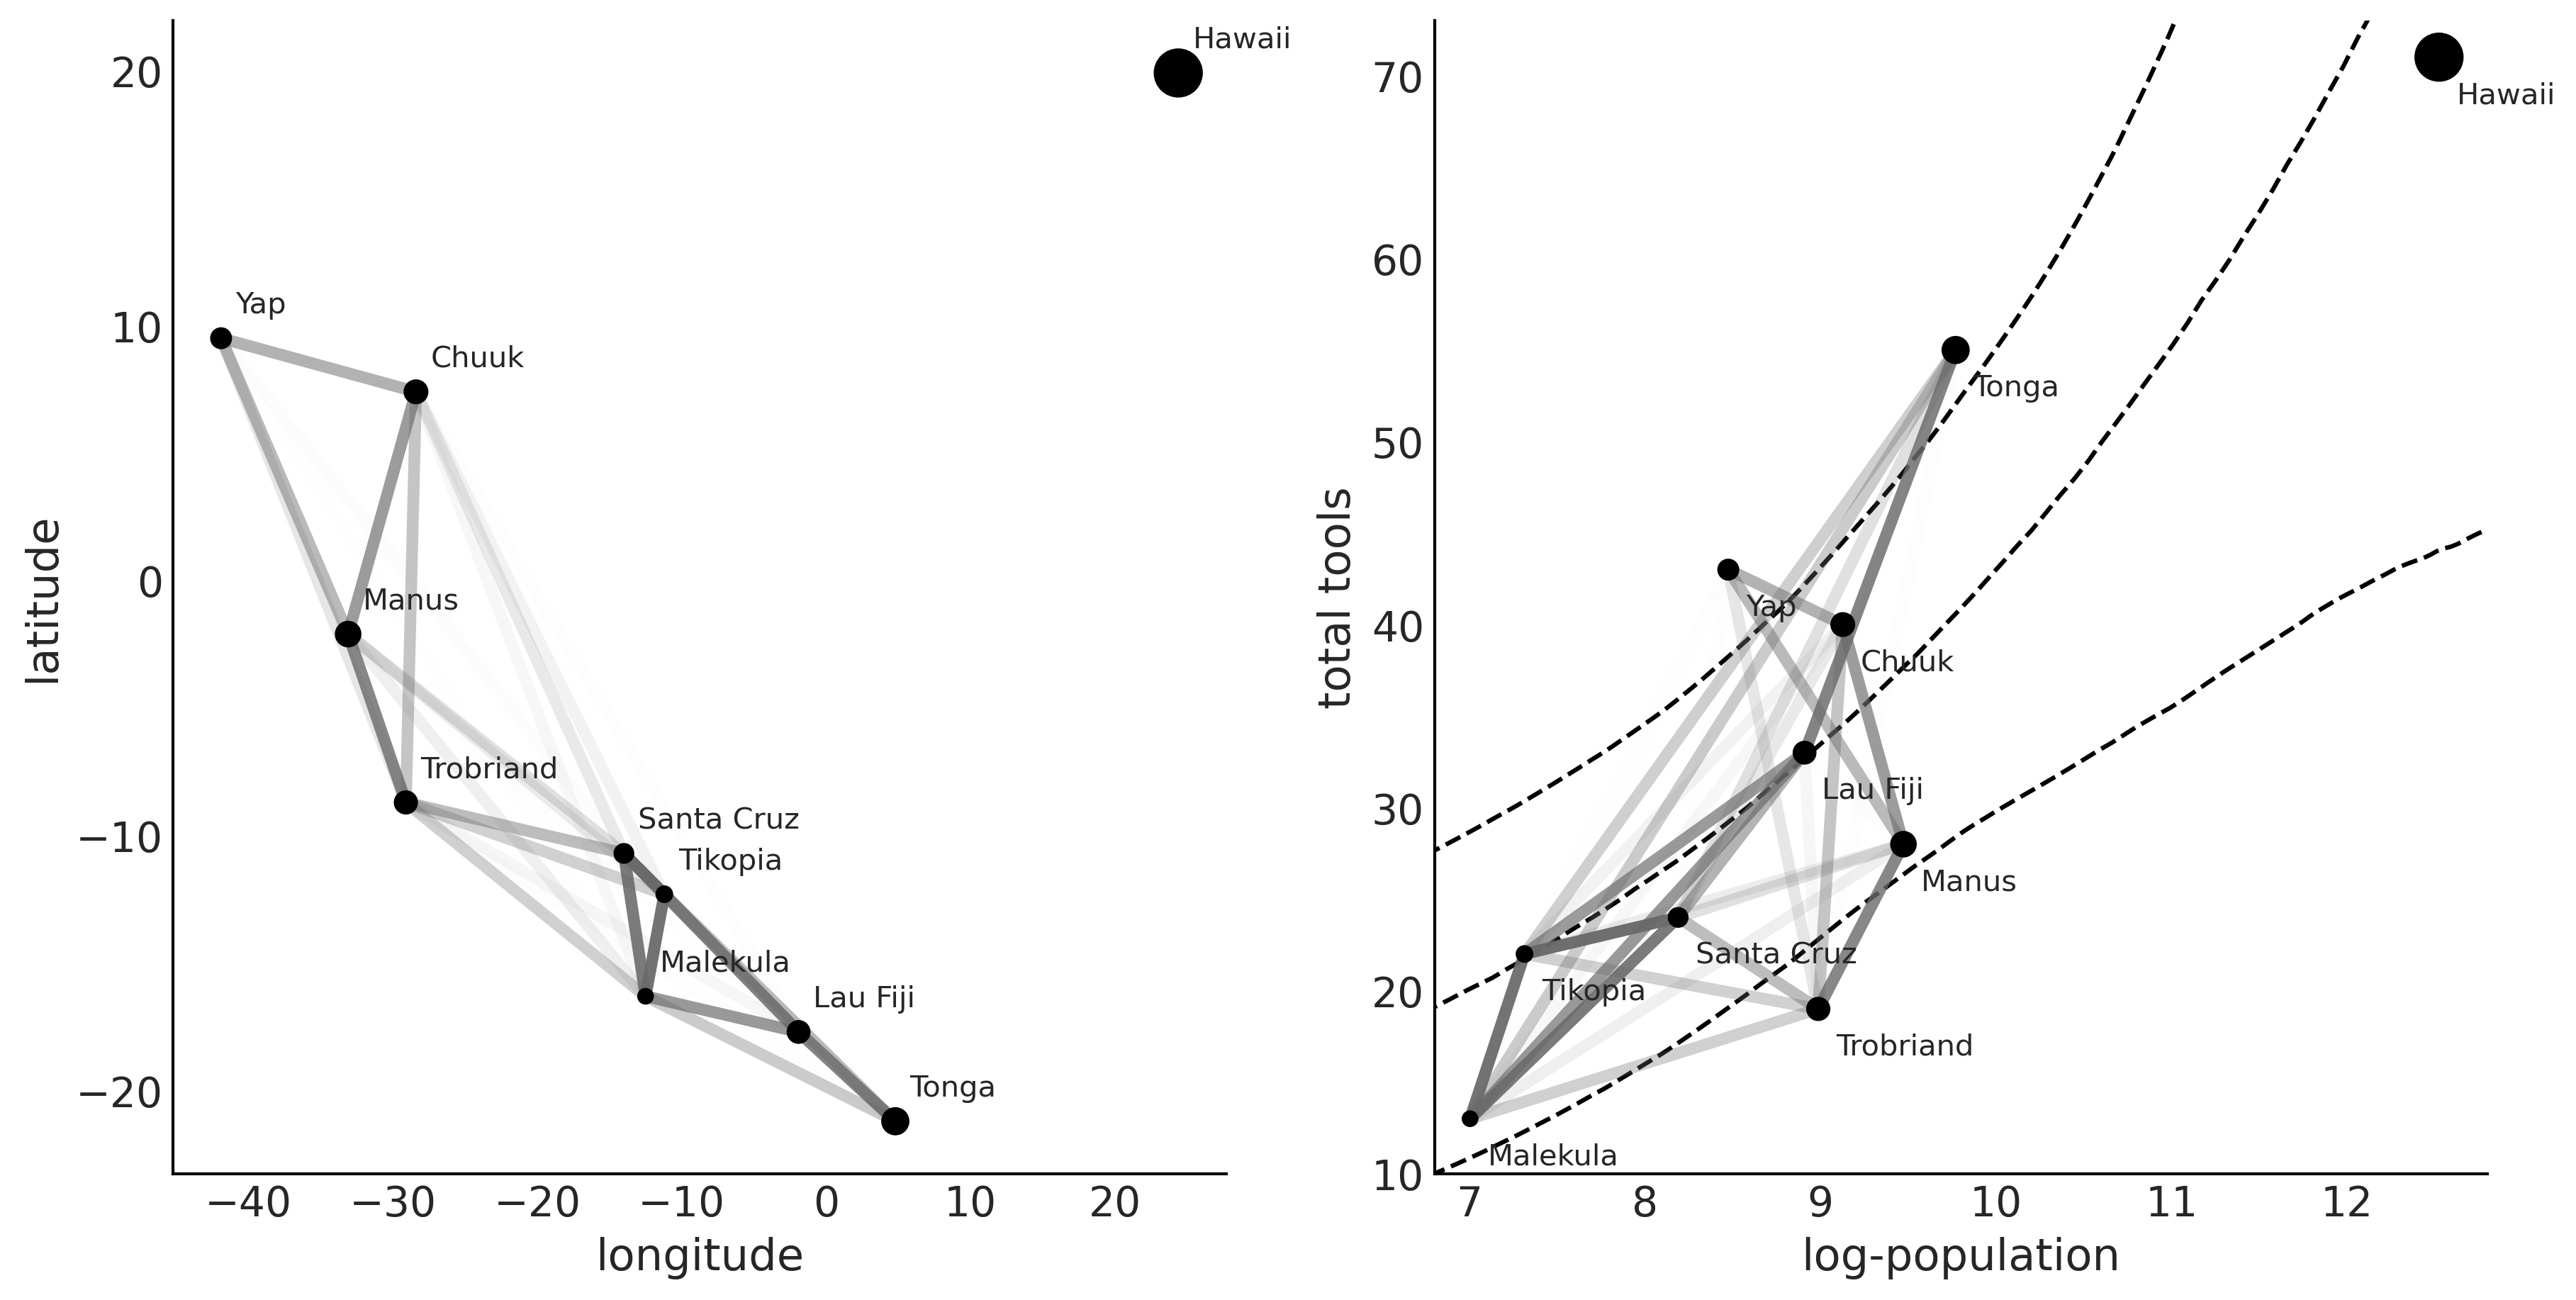

In [45]:
# scale point size to logpop
logpop = np.copy(log_pop)
logpop /= logpop.max()
psize = np.exp(logpop*5.5)
log_pop_seq = np.linspace(6, 14, 100)
lambda_post = np.exp(posterior_islands['α'].values[:, None] +
                     posterior_islands['β'].values[:, None] * log_pop_seq)

_, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].scatter(islands.lon, islands.lat, psize, zorder=3)
ax[1].scatter(islands.logpop, islands.total_tools, psize, zorder=3)

for i, itext in enumerate(culture_labels):
    ax[0].text(islands.lon[i]+1, islands.lat[i]+1, itext)
    ax[1].text(islands.logpop[i]+.1, islands.total_tools[i]-2.5, itext)


ax[1].plot(log_pop_seq, np.median(lambda_post, axis=0), 'k--')

az.plot_hdi(log_pop_seq, lambda_post,
            hdi_prob=0.8,
            fill_kwargs={'alpha':0},
            plot_kwargs={'color':'k', 'ls':'--', 'alpha':1})


for i in range(10):
    for j in np.arange(i+1, 10):
        ax[0].plot((islands.lon[i], islands.lon[j]),
                   (islands.lat[i], islands.lat[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
        ax[1].plot((islands.logpop[i], islands.logpop[j]),
                   (islands.total_tools[i], islands.total_tools[j]), 'C1-',
                   alpha=ρ.iloc[i, j]**2, lw=4)
ax[0].set_xlabel('longitude')
ax[0].set_ylabel('latitude')


ax[1].set_xlabel('log-population')
ax[1].set_ylabel('total tools')
ax[1].set_xlim(6.8, 12.8)
ax[1].set_ylim(10, 73)
plt.savefig('../fig/GP_islands_spatial.png')

## HSGPs

In [46]:
bikes = pd.read_csv("data/bikes.csv")
y = bikes["rented"].values
X = bikes["hour"].values[:,None]

In [47]:
l_hdi = pz.InverseGamma(**get_ig_params(X)).hdi(mass=0.99)
S = (X.max() - X.min()) / 2
c = 1.5
np.mean([1.75 * c / (l/S) for l in l_hdi])

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


8.889691891100702

In [48]:
with pm.Model() as model_hsgp:
    ℓ = pm.InverseGamma('ℓ', **get_ig_params(X))

    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    f = gp.prior('f', X=X)
    α = pm.HalfNormal('α', 1)
    _ = pm.NegativeBinomial("obs", np.exp(f), α, observed=y)

    idata_hsgp = pm.sample(random_seed=123)


/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, f_hsgp_coeffs_, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.


In [49]:
az.summary(idata_hsgp, var_names=["ℓ", "α"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
ℓ  3.413  0.277   2.919    3.941      0.008    0.006    1140.0    1475.0   
α  1.850  0.140   1.587    2.114      0.003    0.002    2907.0    2431.0   

   r_hat  
ℓ    1.0  
α    1.0

array([[<Axes: title={'center': 'ℓ'}>, <Axes: title={'center': 'ℓ'}>],
       [<Axes: title={'center': 'α'}>, <Axes: title={'center': 'α'}>]],
      dtype=object)

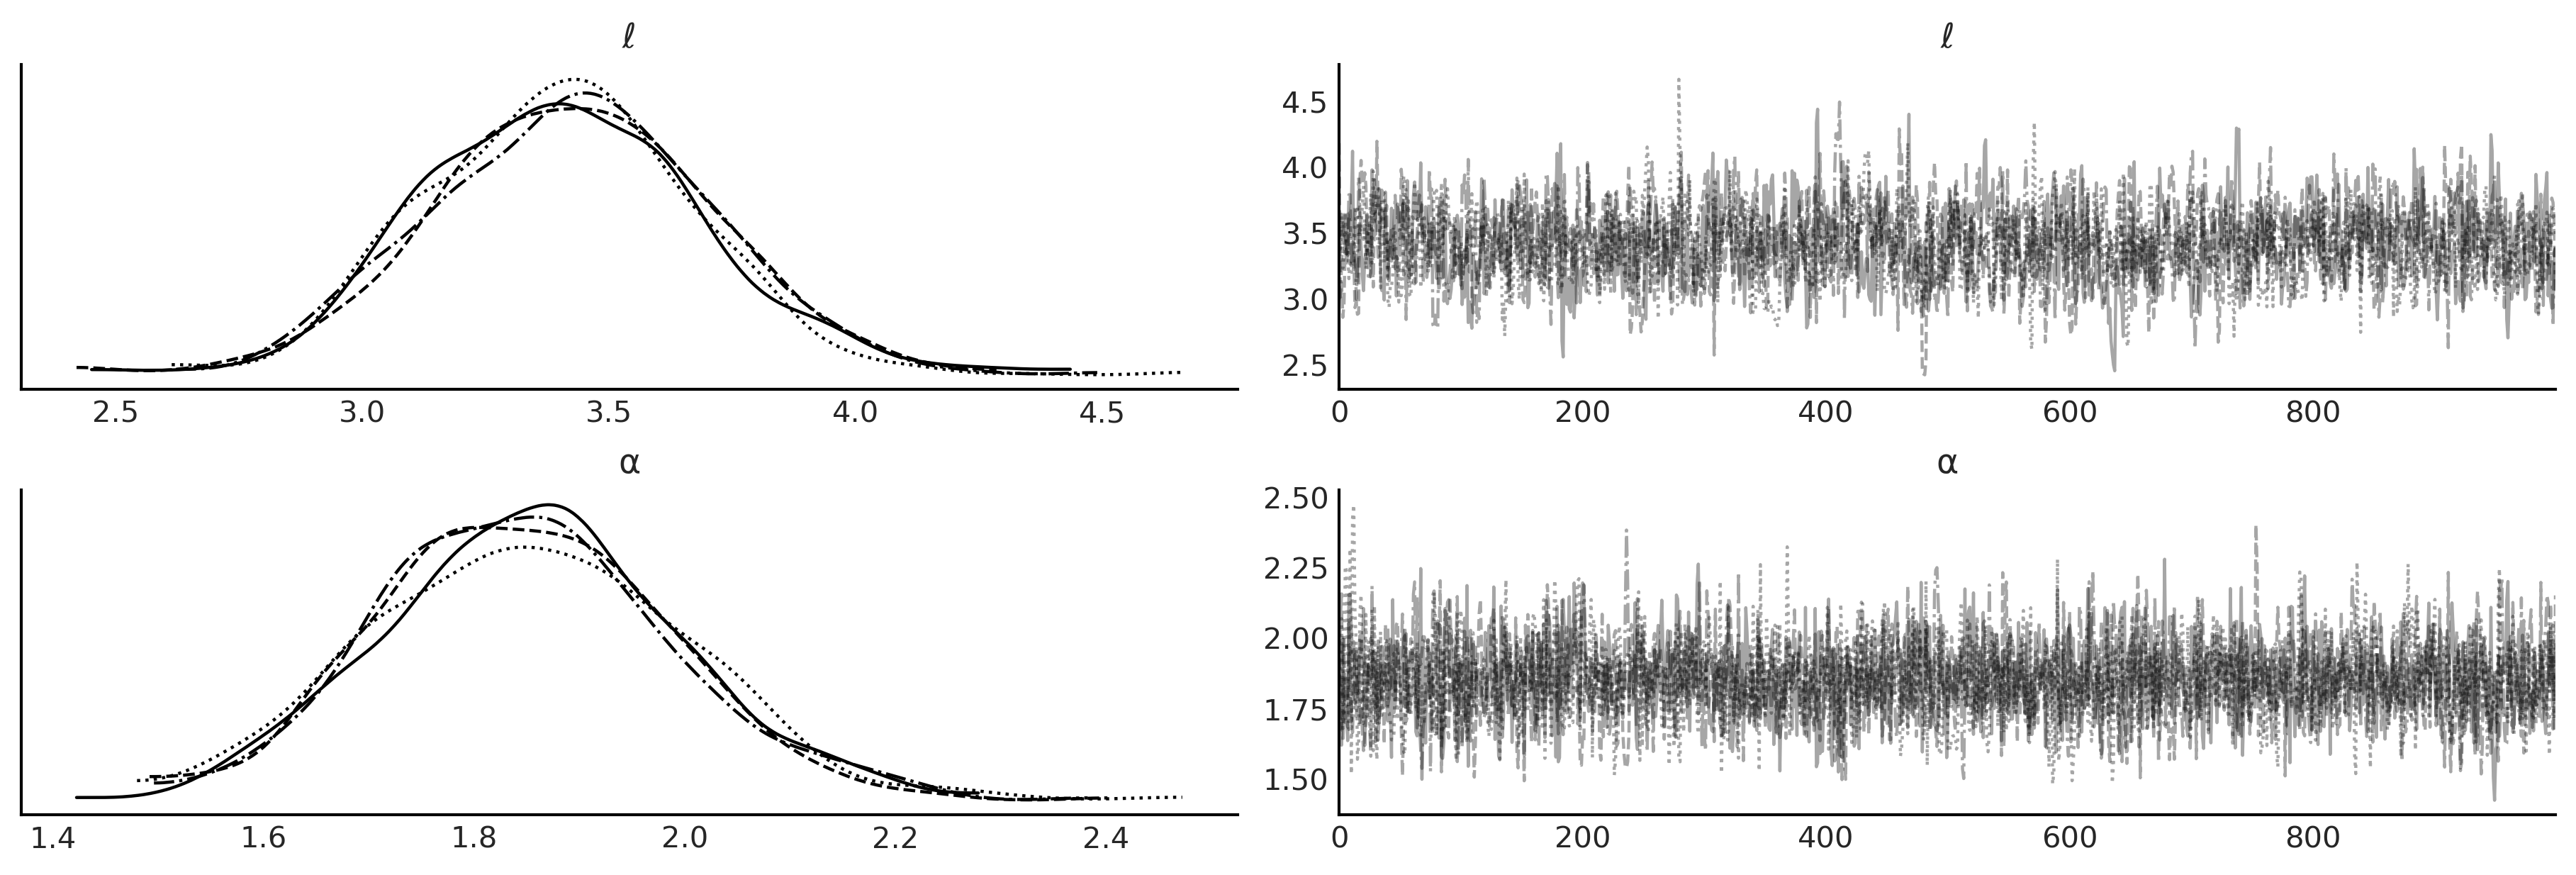

In [50]:
az.plot_trace(idata_hsgp, var_names=["ℓ", "α"])

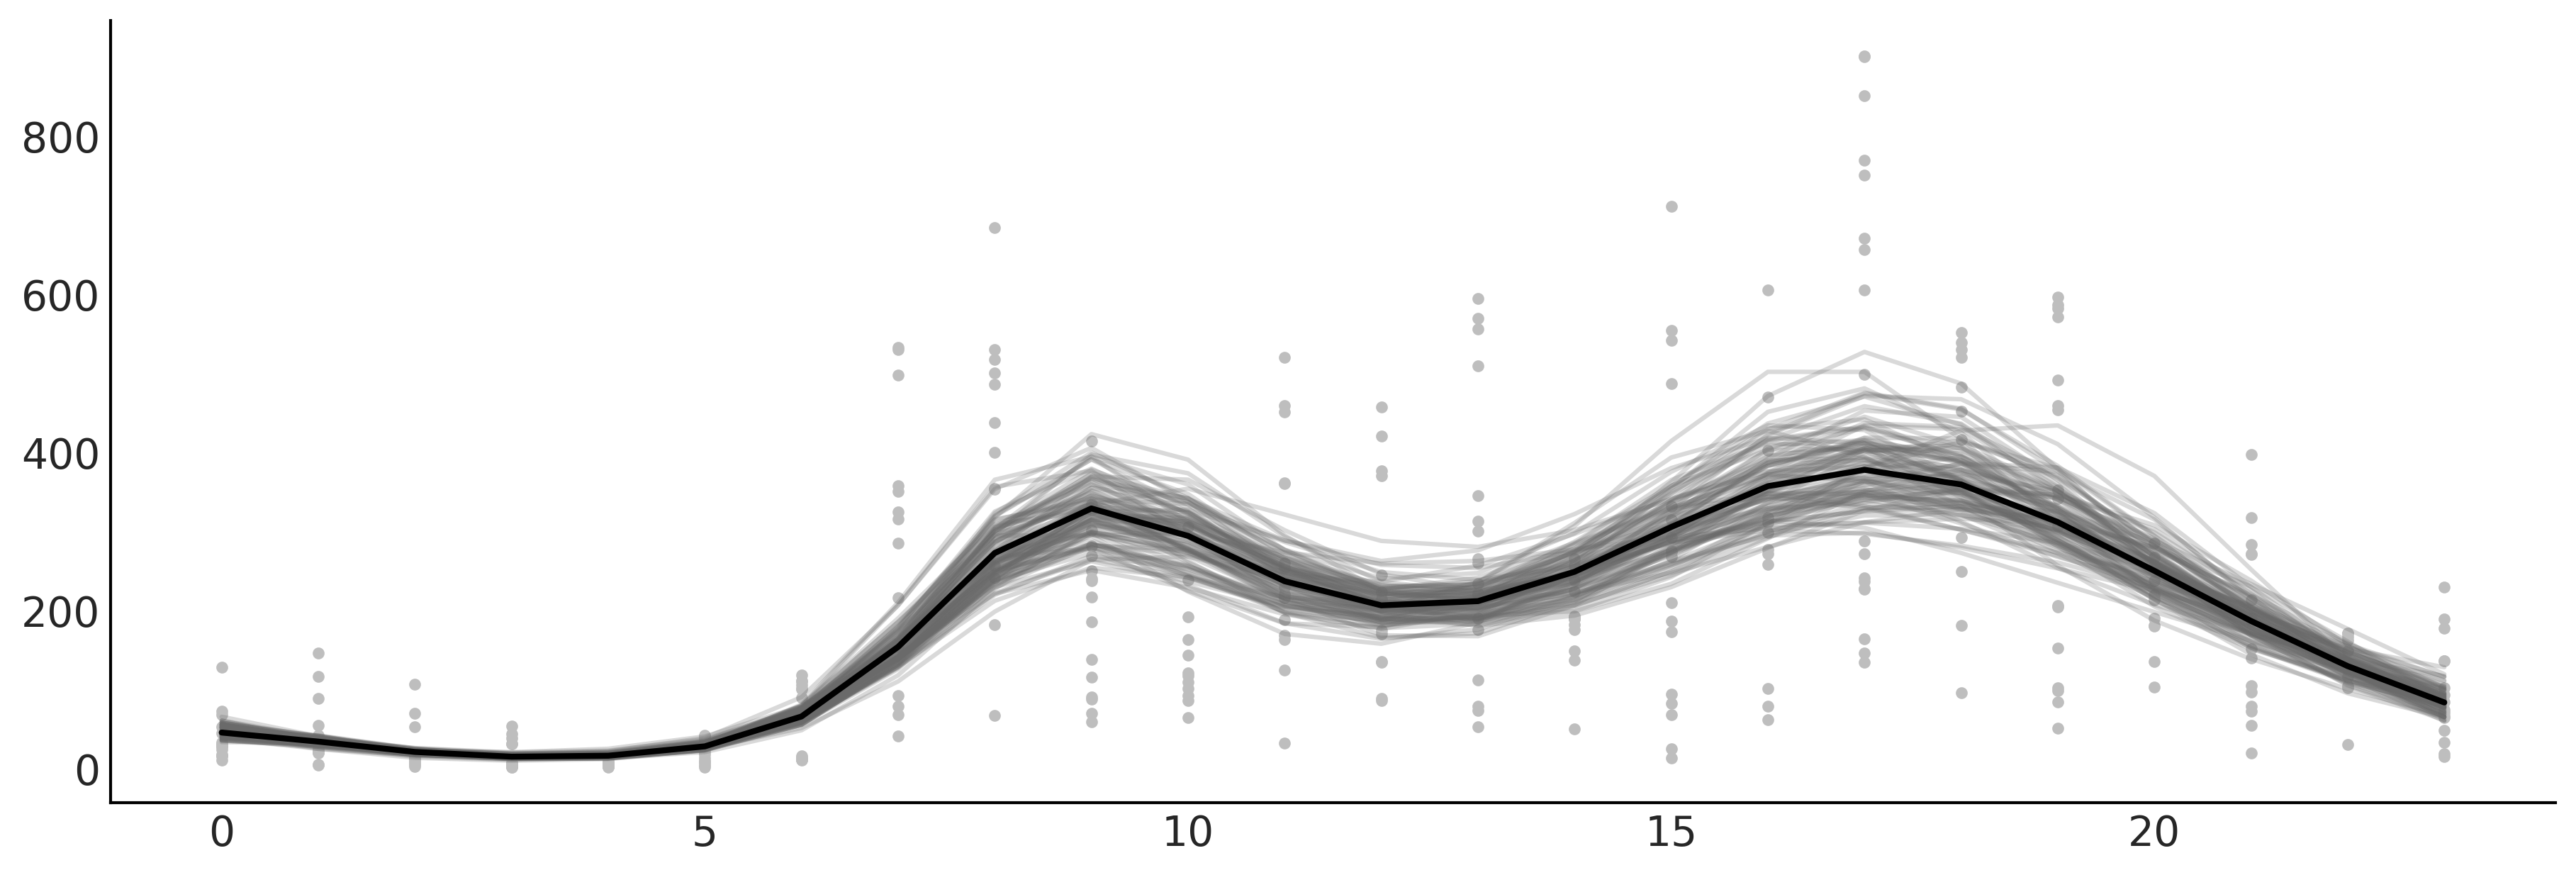

In [51]:
_, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(bikes["hour"].values, bikes["rented"].values, "C2.")


f = az.extract(idata_hsgp, group="posterior", var_names="f")
idx = np.argsort(X[:,0])
ax.plot(bikes["hour"].values[idx], np.exp(f.values[idx,:100]), alpha=0.25, color="C1")

ax.plot(bikes["hour"].values[idx], np.exp(f.values[idx].mean(1)), color="C0", lw=2)
plt.savefig("../fig/gp_HSGP_bikes.png");

In [52]:
prior_gp = {
    "sigma": bmb.Prior("Gamma", mu=1, sigma=0.01),
    "ell": bmb.Prior("InverseGamma", **get_ig_params(X)) 
}

priors = {
    "hsgp(hour, m=10, c=1.5)": prior_gp,
    "alpha": bmb.Prior("HalfNormal", sigma=1)
}

model_hsb = bmb.Model("rented ~ 0 + hsgp(hour, m=10, c=1.5)", bikes, family="negativebinomial", priors=priors)
idata_hsb = model_hsb.fit(random_seed=123)

/home/osvaldo/anaconda3/envs/bap3/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2066: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rented_alpha, hsgp(hour, m=10, c=1.5)_sigma, hsgp(hour, m=10, c=1.5)_ell, hsgp(hour, m=10, c=1.5)_weights_raw]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 63 seconds.


In [53]:
az.summary(idata_hsb, var_names=["hsgp(hour, m=10, c=1.5)_ell", "rented_alpha"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
hsgp(hour, m=10, c=1.5)_ell  3.397  0.272   2.860    3.891      0.007   
rented_alpha                 1.857  0.139   1.611    2.128      0.002   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
hsgp(hour, m=10, c=1.5)_ell    0.005    1384.0    1485.0    1.0  
rented_alpha                   0.002    3567.0    2344.0    1.0

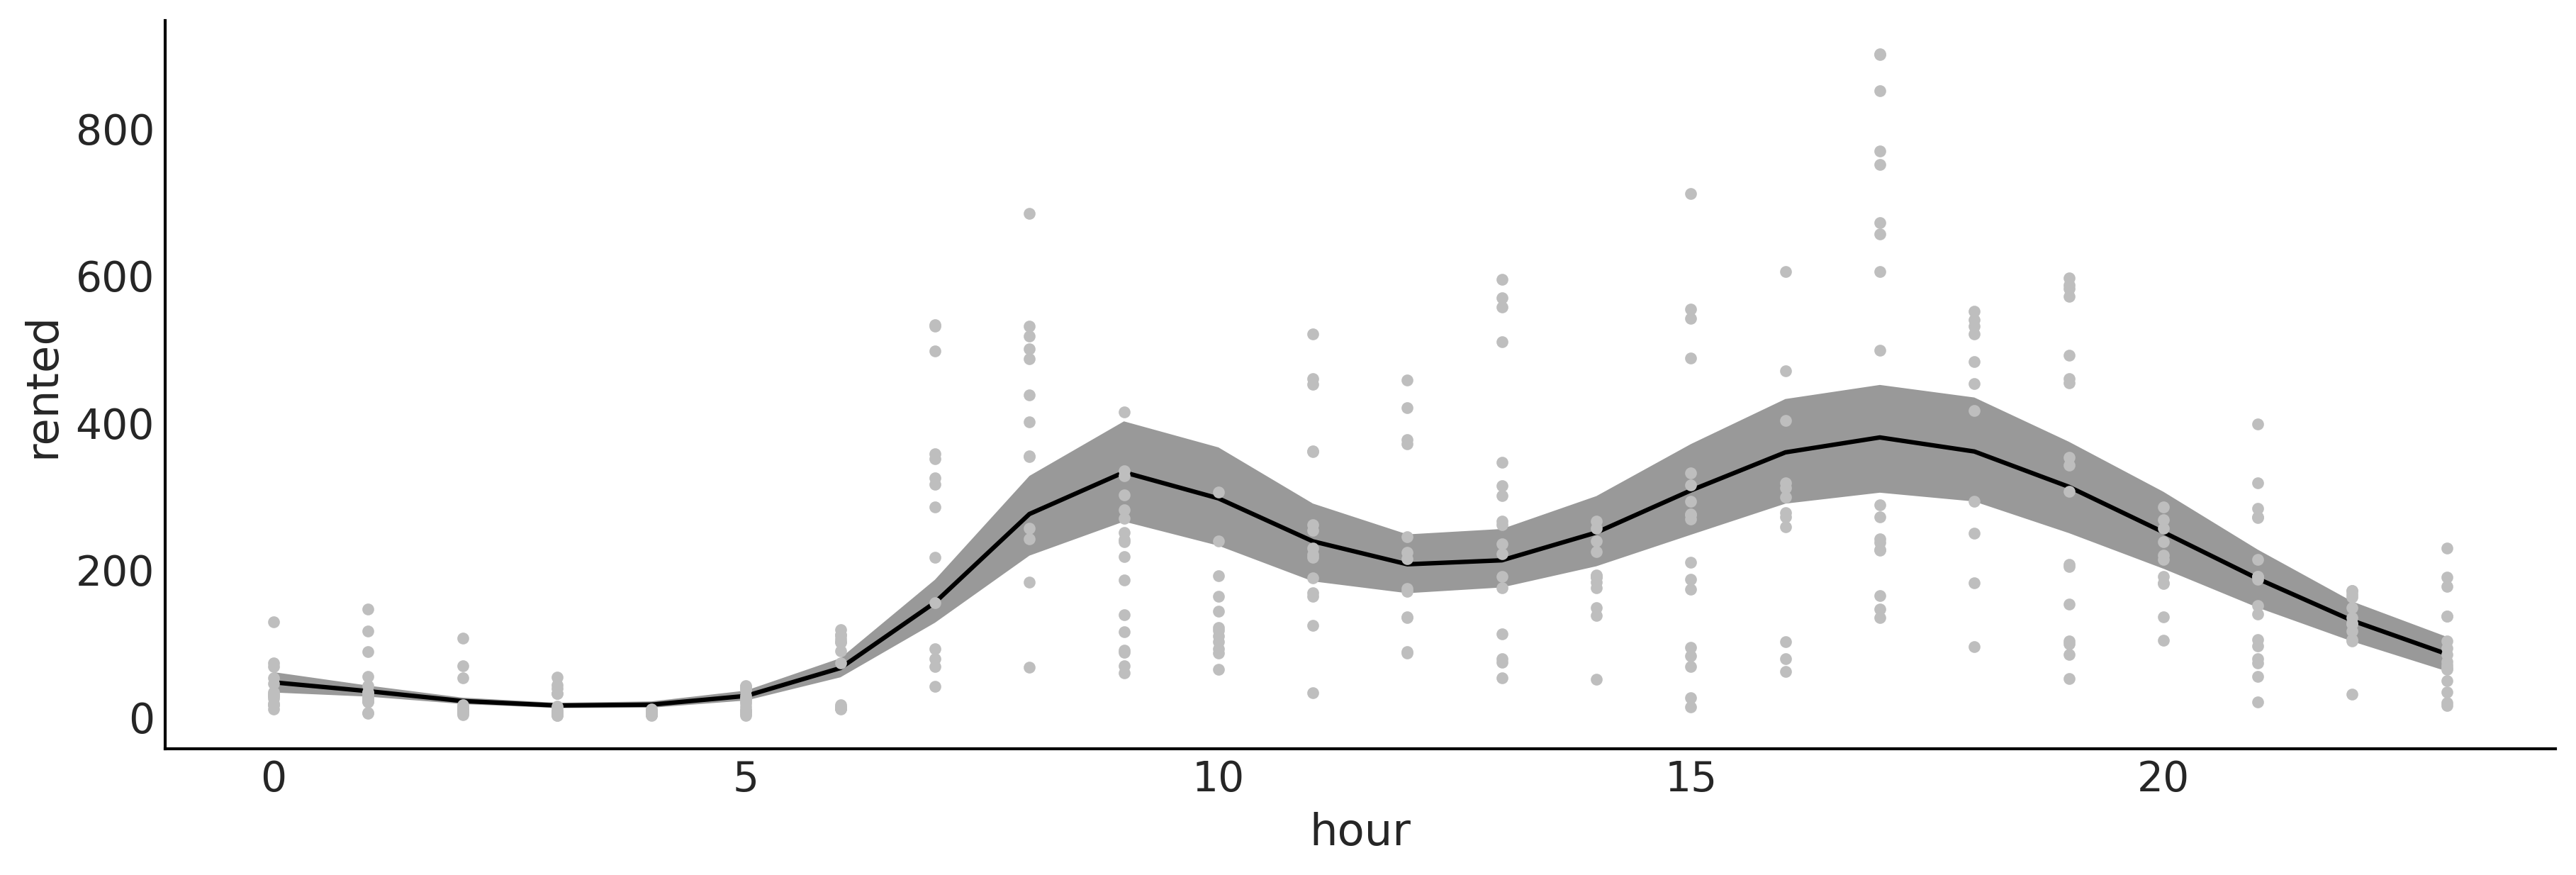

In [54]:
_, ax = bmb.interpret.plot_predictions(model_hsb, idata_hsb, ["hour"],
                                       fig_kwargs={"figsize": (12, 4)})
ax[0].plot(bikes["hour"].values, bikes["rented"].values, "C2.")
plt.savefig("../fig/gp_HSGP_bikes_bambi.png")